In [2]:
#!pip install import-ipynb
#import import_ipynb
#import revrecforecastlibv1
import requests
import json
import pandas as pd
import numpy as np
import seaborn as sns
from pandas.io.json import json_normalize

import datetime
from dateutil.tz import tzutc

In [3]:
#Definitions

today = pd.to_datetime('today').normalize()
current_eom = today + pd.offsets.MonthEnd(0)
start_date = "2017-01-01"
end_date = current_eom + pd.offsets.MonthEnd(11)
studio_debug = "London"
debug = True

def get_json(df):
    """ Small function to serialise DataFrame dates as 'YYYY-MM-DD' in JSON """

    def convert_timestamp(item_date_object):
        if isinstance(item_date_object, (datetime.date, datetime.datetime)):
            return item_date_object.strftime("%Y-%m-%d")
    
    dict_ = df.to_dict(orient="records")

    return json.dumps(dict_, default=convert_timestamp)

#display count and summary of any dataframe
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)
pd.set_option('display.precision', 1)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def difflist(li1, li2): 
    return (list(set(li1) - set(li2)))

def addlist(li1, li2): 
    return (li1.append(li2))

def remove_percetage(df, column_list):
    for col in column_list:
        df[col] = round(df[col].str.replace('%','').astype(np.float64) / 100, 4)
    return df

def coerce_df_columns_to_numeric(df):
    cols_float1 = list(df.filter(like='Rate', axis=1).columns)
    cols_float2 = list(df.filter(like='Yield', axis=1).columns)
    cols_float3 = list(df.filter(like='Diff%', axis=1).columns)
    cols_float4 = list(df.filter(like='Relative_Offset', axis=1).columns)
    cols_float5 = list(df.filter(like='sp500', axis=1).columns)
    cols_float6 = list(df.filter(like='Return', axis=1).columns)
    cols_float = cols_float1 + cols_float2 + cols_float3 + cols_float4 + cols_float5 + cols_float6
    #display("cols_float:", cols_float)
    cols_int1 = list(df.filter(like='Revenue', axis=1).columns)
    cols_int2 = list(df.filter(like='Conversions', axis=1).columns)
    cols_int3 = list(df.filter(like='Value', axis=1).columns)
    cols_int4 = list(df.filter(like='Pipeline', axis=1).columns)
    cols_int5 = list(df.filter(like='Offset', axis=1).columns)
    cols_int6 = list(df.filter(like='Headcount', axis=1).columns)
    cols_int = cols_int1 + cols_int2 + cols_int3 + cols_int4 + cols_int5 + cols_int6
    #display("cols_int:", cols_int)
    cols1 = list(df.select_dtypes(include='float64').columns)
    cols = cols1 + cols_int
    #display("cols:", cols)
    final_cols = difflist(cols,cols_float)
    #display("final_cols:", final_cols)
    df[final_cols] = df[final_cols].apply(pd.to_numeric, errors='coerce')
    df[final_cols] = df[final_cols].replace(np.nan, 0, regex=True)
    df[final_cols] = df[final_cols].astype(int)
    df[final_cols] = round(df[final_cols],0)
    #return df

def data_prep(df):
    df.columns = df.columns.astype(str).str.replace(" ", "_")
    if 'End_of_Month' in df.columns:
        df['End_of_Month'] = pd.to_datetime(df['End_of_Month']) #Format Date
    if 'Snapshot_Date_Short' in df.columns:
        df['Snapshot_Date_Short'] = pd.to_datetime(df['Snapshot_Date_Short']) #Format Date
    df = df.query('Studio not in @exclude_studio')
    df = df.replace(np.nan, 0, regex=True)
    return df

def show_stats(df):   
    print("\n DF Name: \n")
    display(get_df_name(df))
    print("\n DF Info: \n")
    display(df.info(verbose=True))
    print("\n DF Describe: \n")
    display(df.describe(include='all').transpose().head())
    print("\n DF Head: \n")
    display(df.head())
    print("\n DF Tail: \n")
    display(df.tail())
    group_by_studio = df.groupby(by=['Studio'], as_index=False)
    studio_sum = group_by_studio.sum().reset_index(drop=True)
    studio_count = group_by_studio.count().reset_index(drop=True)
    print("\n Studio Sum: \n")
    display(studio_sum.head())
    print("\n Studio Count: \n")
    display(studio_count.head())
    if 'End_of_Month' in df.columns:
        df['End_of_Month'] = pd.to_datetime(df['End_of_Month']) #Format Date
        group_by_eom = df.groupby(by=['End_of_Month'], as_index=False)
        eom_sum = group_by_eom.sum().reset_index(drop=True)
        eom_count = group_by_eom.count().reset_index(drop=True)
        print("\n EOM Sum:")
        display(eom_sum.head())
        print("\n EOM Count: \n")
        display(eom_count.head())
    if 'Snapshot_Date_Short' in df.columns:
        df['Snapshot_Date_Short'] = pd.to_datetime(df['Snapshot_Date_Short']) #Format Date
        group_by_sds = df.groupby(by=['Snapshot_Date_Short'], as_index=False)
        sds_sum = group_by_sds.sum().reset_index(drop=True)
        sds_count = group_by_sds.count().reset_index(drop=True)
        print("\n SDS Sum:")
        display(sds_sum.head())
        print("\n SDS Count: \n")
        display(sds_count.head())
    return

In [4]:
#read input files
talenthist = pd.read_csv("TalentHistory.csv")
pipehist = pd.read_csv("PipelineHistory.csv")
revhist = pd.read_csv("RevenueHistory.csv")
#pipetrend = pd.read_csv("PipelineTrend.csv")
opphist = pd.read_csv("OppHistory.csv")
projhist = pd.read_csv("ProjectHistory.csv")


 SP500: 



'SP500'


 DF Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55 entries, 1 to 55
Data columns (total 4 columns):
End_of_Month         55 non-null datetime64[ns]
sp500                55 non-null float64
Monthly_Return       55 non-null float64
sp500_1M_Previous    55 non-null float64
dtypes: datetime64[ns](1), float64(3)
memory usage: 2.1 KB


None


 SP500 Describe: 



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,55,55,2017-11-30 00:00:00,1,2016-02-29 00:00:00,2020-08-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sp500,55.000000,NaN,NaN,NaN,NaN,NaN,2647.657818,364.660315,1932.230000,2373.920000,2704.100000,2920.220000,3500.310000
Monthly_Return,55.000000,NaN,NaN,NaN,NaN,NaN,0.011674,0.042248,-0.125119,0.000079,0.017859,0.032155,0.126844
sp500_1M_Previous,55.000000,NaN,NaN,NaN,NaN,NaN,2619.292909,357.717528,1932.230000,2363.180000,2673.610000,2913.205000,3271.120000



 SP500 Head: 



,End_of_Month,sp500,Monthly_Return,sp500_1M_Previous
1,2016-02-29,1932.230000,-0.004128,1940.240000
2,2016-03-31,2059.740000,0.065991,1932.230000
3,2016-04-30,2065.300000,0.002699,2059.740000
4,2016-05-31,2096.960000,0.015329,2065.300000
5,2016-06-30,2098.860000,0.000906,2096.960000



 SP500 Tail: 



,End_of_Month,sp500,Monthly_Return,sp500_1M_Previous
51,2020-04-30,2912.430000,0.126844,2584.590000
52,2020-05-31,3044.310000,0.045282,2912.430000
53,2020-06-30,3100.290000,0.018388,3044.310000
54,2020-07-31,3271.120000,0.055101,3100.290000
55,2020-08-31,3500.310000,0.070065,3271.120000


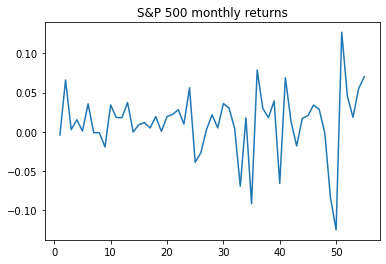

In [5]:
#download SP500 closing prices
#if you get an error after executing the code, try adding below. 
#!pip install pandas-datareader

pd.set_option('display.float_format', lambda x: '%.6f' % x)

start = datetime.datetime(2016, 1, 1)
end = today
#pd.core.common.is_list_like = pd.api.types.is_list_like
#import pandas_datareader.data as web
#SP500 = web.DataReader(['sp500'], 'fred', start, end)
#display(SP500.head())

import pandas_datareader as pdr

SP500 = pdr.get_data_fred('sp500', start, end)
SP500 = SP500.reset_index(level=SP500.index.names)
SP500['End_of_Month'] = SP500['DATE']+ pd.offsets.MonthEnd(0)
SP500 = SP500.sort_values('DATE').groupby('End_of_Month').last()
SP500['Monthly_Return'] = (SP500['sp500']/ SP500['sp500'].shift(1)) -1
SP500['sp500_1M_Previous'] = SP500['sp500'].shift(1)
SP500 = SP500.drop('DATE', axis=1)
SP500 = SP500.reset_index(level=SP500.index.names)

#Drop all Not a number values using drop method.
SP500.dropna(inplace = True)
print("\n SP500: \n")
display(get_df_name(SP500))
print("\n DF Info: \n")
display(SP500.info(verbose=True))
print("\n SP500 Describe: \n")
display(SP500.describe(include='all').transpose().head())
print("\n SP500 Head: \n")
display(SP500.head())
print("\n SP500 Tail: \n")
display(SP500.tail())
SP500['Monthly_Return'].plot(title='S&P 500 monthly returns')

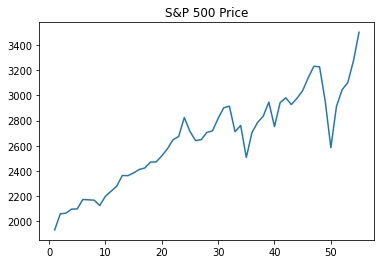

In [6]:
SP500['sp500'].plot(title='S&P 500 Price')

In [7]:
#Rename Studio, filter studio and prep data
pd.set_option('display.float_format', lambda x: '%.2f' % x)
exclude_studio = ["Regional Bay Area", "Regional ChiCamNY", "Palo Alto", "Singapore", "Unknown", "North America"]

#display(exclude_studio)
talenthist1 = talenthist.rename(columns={"Contrib Studio Name": "Studio"})
pipehist1 = pipehist.rename(columns={"Contrib Studio Name": "Studio"})
revhist1 = revhist.rename(columns={"Managing Studio Name": "Studio"})
#pipetrend1 = pipetrend.rename(columns={"Contrib Studio Name": "Studio", 
#                                       "Latest Snapshot Date Short": "Snapshot Date Short",
#                                       "Relative Snapshot Month Offset": "Relative Snapshot Month Offset"})
opphist1 = opphist.rename(columns={"Managing Studio Name": "Studio"})
projhist1 = projhist.rename(columns={"Managing Studio Name": "Studio"})

cols_float1 = opphist1.filter(like='Rate', axis=1).columns
remove_percetage(opphist1, cols_float1)
cols_float2 = pipehist1.filter(like='Yield', axis=1).columns
remove_percetage(pipehist1, cols_float2)

talenthist1 = data_prep(talenthist1)
pipehist1 = data_prep(pipehist1)
revhist1 = data_prep(revhist1)
#pipetrend1 = data_prep(pipetrend1)
opphist1 = data_prep(opphist1)
projhist1 = data_prep(projhist1)

coerce_df_columns_to_numeric(talenthist1)
coerce_df_columns_to_numeric(revhist1)
coerce_df_columns_to_numeric(opphist1)
coerce_df_columns_to_numeric(projhist1)
coerce_df_columns_to_numeric(pipehist1)

#show_stats(pipehist1)

pipehist1['Snapshot_Date_Short'] = pipehist1['Snapshot_Date_Short'] + pd.offsets.MonthEnd(0) #make sure all End of Month are end of month dates
pipehist1['End_of_Month'] = pipehist1['End_of_Month'] + pd.offsets.MonthEnd(0) #make sure all End of Month are end of month dates
#pipetrend1['Snapshot_Date_Short'] = pipetrend1['Snapshot_Date_Short'] + pd.offsets.MonthEnd(0) #make sure all End of Month are end of month dates
opphist1['End_of_Month'] = opphist1['End_of_Month'] + pd.offsets.MonthEnd(0) 
projhist1['End_of_Month'] = projhist1['End_of_Month'] + pd.offsets.MonthEnd(0) 

#Sort
pipehist1.sort_values(by=['Snapshot_Date_Short','End_of_Month','Studio']).reset_index(drop=True)
revhist1.sort_values(by=['End_of_Month','Studio']).reset_index(drop=True)
talenthist1.sort_values(by=['End_of_Month','Studio']).reset_index(drop=True)
#pipetrend1.sort_values(by=['Snapshot_Date_Short','Studio']).reset_index(drop=True)
opphist1.sort_values(by=['End_of_Month','Studio']).reset_index(drop=True)
projhist1.sort_values(by=['End_of_Month','Studio']).reset_index(drop=True)

show_stats(opphist1)


 DF Name: 



'opphist1'


 DF Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 464 entries, 0 to 522
Data columns (total 5 columns):
End_of_Month                       464 non-null datetime64[ns]
Studio                             464 non-null object
Current_Opp._Period_Value          464 non-null int64
Opp_Period_Value_6M_Rolling_Sum    464 non-null int64
Opp_Period_Value_3M_Previous       464 non-null int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 21.8+ KB


None


 DF Describe: 



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,464,31,2020-08-31 00:00:00,17,2018-07-31 00:00:00,2021-01-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Studio,464,17,London,31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Current_Opp._Period_Value,464.00,NaN,NaN,NaN,NaN,NaN,1926274.11,2253990.45,0.00,8250.00,1249910.00,2805125.00,13414533.00
Opp_Period_Value_6M_Rolling_Sum,464.00,NaN,NaN,NaN,NaN,NaN,12211674.71,9509159.40,3000.00,5256446.75,10371624.50,18128570.50,46169936.00
Opp_Period_Value_3M_Previous,464.00,NaN,NaN,NaN,NaN,NaN,2057080.09,2362746.74,0.00,68750.00,1364000.00,2933305.75,13414533.00



 DF Head: 



,End_of_Month,Studio,Current_Opp._Period_Value,Opp_Period_Value_6M_Rolling_Sum,Opp_Period_Value_3M_Previous
0,2018-07-31,Global,0,823000,0
2,2018-07-31,D4L,2850000,4542375,0
3,2018-07-31,Food,2280000,3430000,0
4,2018-07-31,Super,5924053,14994003,0
5,2018-07-31,D4C,953000,3367732,0



 DF Tail: 



,End_of_Month,Studio,Current_Opp._Period_Value,Opp_Period_Value_6M_Rolling_Sum,Opp_Period_Value_3M_Previous
518,2021-01-31,New York,0,1500000,0
519,2021-01-31,London,0,692337,0
520,2021-01-31,Munich,0,572550,0
521,2021-01-31,Shanghai,0,2740031,0
522,2021-01-31,Tokyo,0,490210,0



 Studio Sum: 



,Studio,Current_Opp._Period_Value,Opp_Period_Value_6M_Rolling_Sum,Opp_Period_Value_3M_Previous
0,Cambridge,103589850,657284085,110738847
1,Chicago,112346755,734500815,124430812
2,Creative Leadership,833591,5001546,833591
3,D4C,72133318,444873568,74548050
4,D4L,39240500,243904875,40932875



 Studio Count: 



,Studio,End_of_Month,Current_Opp._Period_Value,Opp_Period_Value_6M_Rolling_Sum,Opp_Period_Value_3M_Previous
0,Cambridge,31,31,31,31
1,Chicago,31,31,31,31
2,Creative Leadership,18,18,18,18
3,D4C,31,31,31,31
4,D4L,31,31,31,31



 EOM Sum:


,End_of_Month,Current_Opp._Period_Value,Opp_Period_Value_6M_Rolling_Sum,Opp_Period_Value_3M_Previous
0,2018-07-31,56821481,117515456,0
1,2018-08-31,42040791,159556249,0
2,2018-09-30,28400977,187957226,60693974
3,2018-10-31,38040208,225997434,56821481
4,2018-11-30,30338866,256336300,42040791



 EOM Count: 



,End_of_Month,Studio,Current_Opp._Period_Value,Opp_Period_Value_6M_Rolling_Sum,Opp_Period_Value_3M_Previous
0,2018-07-31,13,13,13,13
1,2018-08-31,13,13,13,13
2,2018-09-30,14,14,14,14
3,2018-10-31,14,14,14,14
4,2018-11-30,14,14,14,14


In [8]:
print("\n revhist1: \n")
#revhist1.to_csv("revhist1.csv", index=False)
show_stats(revhist1)
display(revhist1.query('Studio==@studio_debug').reset_index(drop=True))
#pivot
revhist_pivot = revhist1.pivot_table(index='End_of_Month', columns='Studio', values='Revenue', aggfunc='count', margins=False)
revhist_pivot = revhist_pivot.reset_index(level=revhist_pivot.index.names)
revhist_pivot


 revhist1: 


 DF Name: 



'revhist1'


 DF Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 679 entries, 0 to 748
Data columns (total 3 columns):
End_of_Month    679 non-null datetime64[ns]
Studio          679 non-null object
Revenue         679 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 21.2+ KB


None


 DF Describe: 



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,679,44,2019-12-31 00:00:00,17,2017-01-31 00:00:00,2020-08-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Studio,679,17,Munich,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenue,679.00,NaN,NaN,NaN,NaN,NaN,725865.54,555725.46,0.00,268285.50,652908.00,994353.50,3096421.00



 DF Head: 



,End_of_Month,Studio,Revenue
0,2017-01-31,Global,54366
3,2017-01-31,SF OS,238538
4,2017-01-31,D4L,601459
5,2017-01-31,Food,365722
6,2017-01-31,Super,1003829



 DF Tail: 



,End_of_Month,Studio,Revenue
744,2020-07-31,Creative Leadership,22434
745,2020-07-31,Tokyo,592122
746,2020-08-31,Global,24342
747,2020-08-31,Munich,3352
748,2020-08-31,Tokyo,0



 Studio Sum: 



,Studio,Revenue
0,Cambridge,53083630
1,Chicago,71538930
2,Creative Leadership,705137
3,D4C,45457332
4,D4L,27985056



 Studio Count: 



,Studio,End_of_Month,Revenue
0,Cambridge,43,43
1,Chicago,43,43
2,Creative Leadership,19,19
3,D4C,43,43
4,D4L,43,43



 EOM Sum:


,End_of_Month,Revenue
0,2017-01-31,9335153
1,2017-02-28,9173656
2,2017-03-31,11264470
3,2017-04-30,9544445
4,2017-05-31,10408480



 EOM Count: 



,End_of_Month,Studio,Revenue
0,2017-01-31,14,14
1,2017-02-28,15,15
2,2017-03-31,15,15
3,2017-04-30,15,15
4,2017-05-31,15,15


,End_of_Month,Studio,Revenue
0,2017-01-31,London,640653
1,2017-02-28,London,686520
2,2017-03-31,London,695914
3,2017-04-30,London,620690
4,2017-05-31,London,480997
5,2017-06-30,London,613119
6,2017-07-31,London,924330
7,2017-08-31,London,652908
8,2017-09-30,London,906711
9,2017-10-31,London,813818


Studio,End_of_Month,Cambridge,Chicago,Creative Leadership,D4C,D4L,Food,Global,Health,London,Munich,New York,OpenIDEO,SF OS,Shanghai,Super,Teachers Guild,Tokyo
0,2017-01-31,1.00,1.00,nan,1.00,1.00,1.00,1.00,nan,1.00,1.00,1.00,1.00,1.00,1.00,1.00,nan,1.00
1,2017-02-28,1.00,1.00,nan,1.00,1.00,1.00,1.00,nan,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
2,2017-03-31,1.00,1.00,nan,1.00,1.00,1.00,1.00,nan,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
3,2017-04-30,1.00,1.00,nan,1.00,1.00,1.00,1.00,nan,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
4,2017-05-31,1.00,1.00,nan,1.00,1.00,1.00,1.00,nan,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
5,2017-06-30,1.00,1.00,nan,1.00,1.00,1.00,1.00,nan,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
6,2017-07-31,1.00,1.00,nan,1.00,1.00,1.00,1.00,nan,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
7,2017-08-31,1.00,1.00,nan,1.00,1.00,1.00,1.00,nan,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
8,2017-09-30,1.00,1.00,nan,1.00,1.00,1.00,1.00,nan,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
9,2017-10-31,1.00,1.00,nan,1.00,1.00,1.00,1.00,nan,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [9]:
print("\n talenthist1: \n")
show_stats(talenthist1)
#pivot
talenthist_pivot = talenthist1.pivot_table(index='End_of_Month', columns='Studio', values='Headcount', aggfunc='count', margins=False)
talenthist_pivot = talenthist_pivot.reset_index(level=talenthist_pivot.index.names)
talenthist_pivot


 talenthist1: 


 DF Name: 



'talenthist1'


 DF Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 881 entries, 0 to 1030
Data columns (total 4 columns):
End_of_Month             881 non-null datetime64[ns]
Studio                   881 non-null object
Headcount                881 non-null int64
Headcount_1M_Previous    881 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 34.4+ KB


None


 DF Describe: 



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,881,55,2021-01-31 00:00:00,17,2017-01-31 00:00:00,2021-07-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Studio,881,17,SF OS,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Headcount,881.00,NaN,NaN,NaN,NaN,NaN,37.29,21.09,1.00,23.00,37.00,47.00,94.00
Headcount_1M_Previous,881.00,NaN,NaN,NaN,NaN,NaN,36.88,21.28,0.00,23.00,37.00,47.00,94.00



 DF Head: 



,End_of_Month,Studio,Headcount,Headcount_1M_Previous
0,2017-01-31,Global,57,92
4,2017-01-31,SF OS,35,0
5,2017-01-31,D4L,21,0
6,2017-01-31,Food,21,0
7,2017-01-31,Super,47,0



 DF Tail: 



,End_of_Month,Studio,Headcount,Headcount_1M_Previous
1026,2021-07-31,London,55,55
1027,2021-07-31,Munich,38,38
1028,2021-07-31,Shanghai,38,38
1029,2021-07-31,Creative Leadership,3,3
1030,2021-07-31,Tokyo,36,36



 Studio Sum: 



,Studio,Headcount,Headcount_1M_Previous
0,Cambridge,2599,2552
1,Chicago,4108,4071
2,Creative Leadership,87,84
3,D4C,2005,1972
4,D4L,1243,1220



 Studio Count: 



,Studio,End_of_Month,Headcount,Headcount_1M_Previous
0,Cambridge,55,55,55
1,Chicago,55,55,55
2,Creative Leadership,31,31,31
3,D4C,55,55,55
4,D4L,55,55,55



 EOM Sum:


,End_of_Month,Headcount,Headcount_1M_Previous
0,2017-01-31,501,307
1,2017-02-28,503,501
2,2017-03-31,508,503
3,2017-04-30,506,508
4,2017-05-31,510,506



 EOM Count: 



,End_of_Month,Studio,Headcount,Headcount_1M_Previous
0,2017-01-31,15,15,15
1,2017-02-28,15,15,15
2,2017-03-31,15,15,15
3,2017-04-30,15,15,15
4,2017-05-31,15,15,15


Studio,End_of_Month,Cambridge,Chicago,Creative Leadership,D4C,D4L,Food,Global,Health,London,Munich,New York,OpenIDEO,SF OS,Shanghai,Super,Teachers Guild,Tokyo
0,2017-01-31,1.00,1.00,nan,1.00,1.00,1.00,1.00,nan,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
1,2017-02-28,1.00,1.00,nan,1.00,1.00,1.00,1.00,nan,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
2,2017-03-31,1.00,1.00,nan,1.00,1.00,1.00,1.00,nan,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
3,2017-04-30,1.00,1.00,nan,1.00,1.00,1.00,1.00,nan,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
4,2017-05-31,1.00,1.00,nan,1.00,1.00,1.00,1.00,nan,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
5,2017-06-30,1.00,1.00,nan,1.00,1.00,1.00,1.00,nan,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
6,2017-07-31,1.00,1.00,nan,1.00,1.00,1.00,1.00,nan,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
7,2017-08-31,1.00,1.00,nan,1.00,1.00,1.00,1.00,nan,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
8,2017-09-30,1.00,1.00,nan,1.00,1.00,1.00,1.00,nan,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
9,2017-10-31,1.00,1.00,nan,1.00,1.00,1.00,1.00,nan,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [10]:
show_stats(projhist1)


 DF Name: 



'projhist1'


 DF Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837 entries, 0 to 885
Data columns (total 10 columns):
End_of_Month                        837 non-null datetime64[ns]
Studio                              837 non-null object
Conversions                         837 non-null int64
Conversions_3_Month_Rolling_Avg     837 non-null int64
Conversions_3M_Rolling_Sum          837 non-null int64
Conversions_6M_Rolling_Sum          837 non-null int64
Conversions_12_Month_Rolling_Avg    837 non-null int64
Conversions_2M_Previous             837 non-null int64
Conversions_91_Days_Rolling_Avg     837 non-null int64
Conversions_182_Days_Rolling_Avg    837 non-null int64
dtypes: datetime64[ns](1), int64(8), object(1)
memory usage: 71.9+ KB


None


 DF Describe: 



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,837,55,2019-10-31 00:00:00,17,2017-01-31 00:00:00,2021-07-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Studio,837,17,Munich,55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Conversions,837.00,NaN,NaN,NaN,NaN,NaN,551212.66,987181.96,0.00,0.00,100000.00,699527.00,10141851.00
Conversions_3_Month_Rolling_Avg,837.00,NaN,NaN,NaN,NaN,NaN,617778.32,730251.28,-275167.00,27857.00,392910.00,880093.00,4378968.00
Conversions_3M_Rolling_Sum,837.00,NaN,NaN,NaN,NaN,NaN,1661783.55,2129927.95,-825501.00,35475.00,917094.00,2349975.00,13136906.00



 DF Head: 



,End_of_Month,Studio,Conversions,Conversions_3_Month_Rolling_Avg,Conversions_3M_Rolling_Sum,Conversions_6M_Rolling_Sum,Conversions_12_Month_Rolling_Avg,Conversions_2M_Previous,Conversions_91_Days_Rolling_Avg,Conversions_182_Days_Rolling_Avg
0,2017-01-31,Global,47470,39585,79170,1091371,206895,31700,0,0
2,2017-01-31,D4L,1500000,839166,2517500,4490123,819235,618000,0,0
3,2017-01-31,Food,590000,671500,2014500,3055000,542777,246500,0,0
4,2017-01-31,Super,2100000,1061250,2122500,5597500,1196433,0,0,139000
5,2017-01-31,D4C,1475000,753000,2259000,4811000,970818,240000,0,50000



 DF Tail: 



,End_of_Month,Studio,Conversions,Conversions_3_Month_Rolling_Avg,Conversions_3M_Rolling_Sum,Conversions_6M_Rolling_Sum,Conversions_12_Month_Rolling_Avg,Conversions_2M_Previous,Conversions_91_Days_Rolling_Avg,Conversions_182_Days_Rolling_Avg
881,2021-07-31,New York,0,0,0,0,200000,0,0,0
882,2021-07-31,Munich,0,0,0,0,561099,0,0,0
883,2021-07-31,Shanghai,0,0,0,0,917094,0,0,0
884,2021-07-31,Creative Leadership,0,0,0,0,35650,0,0,0
885,2021-07-31,Tokyo,0,0,0,0,1709158,0,0,0



 Studio Sum: 



,Studio,Conversions,Conversions_3_Month_Rolling_Avg,Conversions_3M_Rolling_Sum,Conversions_6M_Rolling_Sum,Conversions_12_Month_Rolling_Avg,Conversions_2M_Previous,Conversions_91_Days_Rolling_Avg,Conversions_182_Days_Rolling_Avg
0,Cambridge,45173871,46952109,139088365,287046655,56364903,47263222,6531496,8459816
1,Chicago,75973026,78426703,230314356,467627120,91583953,77868303,5173944,7618962
2,Creative Leadership,254424,592009,763272,1526544,1024415,254424,0,0
3,D4C,58300320,57517800,171624005,351306010,63830018,57549335,3021310,2714819
4,D4L,23575842,27017939,70959526,147401175,32881972,24198342,12621000,25679000



 Studio Count: 



,Studio,End_of_Month,Conversions,Conversions_3_Month_Rolling_Avg,Conversions_3M_Rolling_Sum,Conversions_6M_Rolling_Sum,Conversions_12_Month_Rolling_Avg,Conversions_2M_Previous,Conversions_91_Days_Rolling_Avg,Conversions_182_Days_Rolling_Avg
0,Cambridge,55,55,55,55,55,55,55,55,55
1,Chicago,55,55,55,55,55,55,55,55,55
2,Creative Leadership,29,29,29,29,29,29,29,29,29
3,D4C,55,55,55,55,55,55,55,55,55
4,D4L,55,55,55,55,55,55,55,55,55



 EOM Sum:


,End_of_Month,Conversions,Conversions_3_Month_Rolling_Avg,Conversions_3M_Rolling_Sum,Conversions_6M_Rolling_Sum,Conversions_12_Month_Rolling_Avg,Conversions_2M_Previous,Conversions_91_Days_Rolling_Avg,Conversions_182_Days_Rolling_Avg
0,2017-01-31,10541476,8935241,25321270,47380016,9356850,7712003,99999,652960
1,2017-02-28,7357435,8337217,24966702,46612069,8916074,7067789,99999,652960
2,2017-03-31,8864803,9502255,26763715,47841825,8995457,10541476,99999,652960
3,2017-04-30,5176597,8294519,21398837,46720108,8226856,7357435,149999,652960
4,2017-05-31,6739961,8673360,20781361,45748065,7935602,8864803,50000,149999



 EOM Count: 



,End_of_Month,Studio,Conversions,Conversions_3_Month_Rolling_Avg,Conversions_3M_Rolling_Sum,Conversions_6M_Rolling_Sum,Conversions_12_Month_Rolling_Avg,Conversions_2M_Previous,Conversions_91_Days_Rolling_Avg,Conversions_182_Days_Rolling_Avg
0,2017-01-31,13,13,13,13,13,13,13,13,13
1,2017-02-28,13,13,13,13,13,13,13,13,13
2,2017-03-31,13,13,13,13,13,13,13,13,13
3,2017-04-30,14,14,14,14,14,14,14,14,14
4,2017-05-31,14,14,14,14,14,14,14,14,14


In [11]:
show_stats(pipehist1)


 DF Name: 



'pipehist1'


 DF Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17548 entries, 0 to 19739
Data columns (total 13 columns):
Snapshot_Date_Short               17548 non-null datetime64[ns]
Relative_Snapshot_Month_Offset    17548 non-null int64
End_of_Month                      17548 non-null datetime64[ns]
Relative_Month_Offset             17548 non-null int64
Studio                            17548 non-null object
Pipeline                          17548 non-null int64
Active_Unrecognized_Revenue       17548 non-null int64
Opportunity_Revenue               17548 non-null int64
Pipeline_3_Month_Rolling_Avg      17548 non-null int64
Pipeline_3_Month_Rolling_Sum      17548 non-null int64
Pipeline_MoM                      17548 non-null int64
Pipeline_3M_Forward_Sum           17548 non-null int64
Pipeline_3M_Forward_Avg           17548 non-null int64
dtypes: datetime64[ns](2), int64(10), object(1)
memory usage: 1.9+ MB


None


 DF Describe: 



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date_Short,17548,26,2020-08-31 00:00:00,864,2018-07-31 00:00:00,2020-08-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Snapshot_Month_Offset,17548.00,NaN,NaN,NaN,NaN,NaN,-11.02,7.30,-25.00,-17.00,-10.00,-5.00,0.00
End_of_Month,17548,55,2018-11-30 00:00:00,409,2017-01-31 00:00:00,2021-07-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Month_Offset,17548.00,NaN,NaN,NaN,NaN,NaN,-20.54,13.82,-43.00,-32.00,-21.00,-10.00,11.00
Studio,17548,17,Cambridge,1230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



 DF Head: 



,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Studio,Pipeline,Active_Unrecognized_Revenue,Opportunity_Revenue,Pipeline_3_Month_Rolling_Avg,Pipeline_3_Month_Rolling_Sum,Pipeline_MoM,Pipeline_3M_Forward_Sum,Pipeline_3M_Forward_Avg
0,2018-07-31,-25,2017-01-31,-43,Global,54366,0,0,586756,1173513,-1064779,181766,60588
3,2018-07-31,-25,2017-01-31,-43,SF OS,238538,0,0,1463127,2926255,-2449179,585210,195070
4,2018-07-31,-25,2017-01-31,-43,D4L,601459,0,0,4108763,8217526,-7014607,1904967,634989
5,2018-07-31,-25,2017-01-31,-43,Food,365722,0,0,2843832,5687664,-4956219,1462912,487637
6,2018-07-31,-25,2017-01-31,-43,Super,1003829,0,0,7803664,15607329,-13599669,3366484,1122161



 DF Tail: 



,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Studio,Pipeline,Active_Unrecognized_Revenue,Opportunity_Revenue,Pipeline_3_Month_Rolling_Avg,Pipeline_3_Month_Rolling_Sum,Pipeline_MoM,Pipeline_3M_Forward_Sum,Pipeline_3M_Forward_Avg
19735,2020-08-31,0,2021-07-31,11,Cambridge,80397,0,80397,87303,261911,-612,241191,80397
19736,2020-08-31,0,2021-07-31,11,Chicago,0,0,0,19934,39868,-2727,0,0
19737,2020-08-31,0,2021-07-31,11,New York,0,0,0,32573,65146,-27182,0,0
19738,2020-08-31,0,2021-07-31,11,Shanghai,0,0,0,5178,10357,-900,0,0
19739,2020-08-31,0,2021-07-31,11,Tokyo,0,0,0,13863,13863,0,0,0



 Studio Sum: 



,Studio,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline,Active_Unrecognized_Revenue,Opportunity_Revenue,Pipeline_3_Month_Rolling_Avg,Pipeline_3_Month_Rolling_Sum,Pipeline_MoM,Pipeline_3M_Forward_Sum,Pipeline_3M_Forward_Avg
0,Cambridge,-14035,-23664,1157905893,94529680,90502411,1468309941,4202783208,-364860789,3368065948,1123163836
1,Chicago,-13455,-23438,1563386257,148847226,120285242,1835336032,5326177147,-318179874,4596346237,1533619712
2,Creative Leadership,-2767,-4019,11325184,3010850,762266,12152213,33424749,7,33424749,12152213
3,D4C,-13055,-23881,1000871164,102809507,77549388,1245714831,3575058593,-286337087,2917076178,973779593
4,D4L,-12255,-23739,606966300,40444440,44621328,775782806,2216935463,-198017623,1774329535,592638234



 Studio Count: 



,Studio,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Active_Unrecognized_Revenue,Opportunity_Revenue,Pipeline_3_Month_Rolling_Avg,Pipeline_3_Month_Rolling_Sum,Pipeline_MoM,Pipeline_3M_Forward_Sum,Pipeline_3M_Forward_Avg
0,Cambridge,1230,1230,1230,1230,1230,1230,1230,1230,1230,1230,1230,1230
1,Chicago,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200
2,Creative Leadership,374,374,374,374,374,374,374,374,374,374,374,374
3,D4C,1156,1156,1156,1156,1156,1156,1156,1156,1156,1156,1156,1156
4,D4L,1103,1103,1103,1103,1103,1103,1103,1103,1103,1103,1103,1103



 EOM Sum:


,End_of_Month,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline,Active_Unrecognized_Revenue,Opportunity_Revenue,Pipeline_3_Month_Rolling_Avg,Pipeline_3_Month_Rolling_Sum,Pipeline_MoM,Pipeline_3M_Forward_Sum,Pipeline_3M_Forward_Avg
0,2017-01-31,-4875,-16770,242713978,0,0,1485476462,2970953234,-2485524914,774105564,258704082
1,2017-02-28,-4875,-16380,238515032,0,0,1069879074,3209468472,-4198818,779547134,259848966
2,2017-03-31,-4875,-15990,292876244,0,0,258704082,774105564,54361084,811652634,270550750
3,2017-04-30,-4875,-15600,248155522,0,0,259848966,779547134,-44720668,776156966,258718826
4,2017-05-31,-4875,-15210,270620528,0,0,270550750,811652634,22464978,746484408,248827980



 EOM Count: 



,End_of_Month,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Studio,Pipeline,Active_Unrecognized_Revenue,Opportunity_Revenue,Pipeline_3_Month_Rolling_Avg,Pipeline_3_Month_Rolling_Sum,Pipeline_MoM,Pipeline_3M_Forward_Sum,Pipeline_3M_Forward_Avg
0,2017-01-31,390,390,390,390,390,390,390,390,390,390,390,390
1,2017-02-28,390,390,390,390,390,390,390,390,390,390,390,390
2,2017-03-31,390,390,390,390,390,390,390,390,390,390,390,390
3,2017-04-30,390,390,390,390,390,390,390,390,390,390,390,390
4,2017-05-31,390,390,390,390,390,390,390,390,390,390,390,390



 SDS Sum:


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline,Active_Unrecognized_Revenue,Opportunity_Revenue,Pipeline_3_Month_Rolling_Avg,Pipeline_3_Month_Rolling_Sum,Pipeline_MoM,Pipeline_3M_Forward_Sum,Pipeline_3M_Forward_Avg
0,2018-07-31,-11950,-12792,245961683,34751395,30248054,335247566,946062470,-104908049,708058921,236866318
1,2018-08-31,-11472,-12793,258672007,33250000,33224067,348478167,984103685,-104907813,746190600,250127073
2,2018-09-30,-10488,-12843,269797460,34618114,31072853,359500522,1017553378,-104932242,779493634,261100545
3,2018-10-31,-10648,-13141,270673950,33976779,21277432,360210618,1020182855,-104932236,782123111,261810641
4,2018-11-30,-10395,-13263,289615241,27994318,33197520,379236747,1076383098,-104932227,837386731,280524563



 SDS Count: 



,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Studio,Pipeline,Active_Unrecognized_Revenue,Opportunity_Revenue,Pipeline_3_Month_Rolling_Avg,Pipeline_3_Month_Rolling_Sum,Pipeline_MoM,Pipeline_3M_Forward_Sum,Pipeline_3M_Forward_Avg
0,2018-07-31,478,478,478,478,478,478,478,478,478,478,478,478
1,2018-08-31,478,478,478,478,478,478,478,478,478,478,478,478
2,2018-09-30,456,456,456,456,456,456,456,456,456,456,456,456
3,2018-10-31,484,484,484,484,484,484,484,484,484,484,484,484
4,2018-11-30,495,495,495,495,495,495,495,495,495,495,495,495


In [12]:
# Cross join to get all unquie values of End_of_Month and Studio
d = pd.date_range(start_date,end_date,freq='m')
eom = pd.DataFrame(d, columns=['End_of_Month'])
#eom = pipehist_pivot1[['End_of_Month']].drop_duplicates(subset='End_of_Month',keep="last").sort_values(by=['End_of_Month']).reset_index(drop=True)
studio = pd.DataFrame(talenthist1['Studio'].unique(), columns=['Studio'])
eom['key'] = 0
studio['key'] = 0
eom_studio = pd.merge(eom, studio, on=['key'])
eom_studio = eom_studio.replace(np.nan, "Unknown", regex=True)
eom_studio.drop(columns=['key'], axis=1, inplace = True)
print("\n eom_studio: \n")
display(eom_studio.info(verbose=True))
eom_studio


 eom_studio: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 952 entries, 0 to 951
Data columns (total 2 columns):
End_of_Month    952 non-null datetime64[ns]
Studio          952 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 22.3+ KB


None

,End_of_Month,Studio
0,2017-01-31,Global
1,2017-01-31,SF OS
2,2017-01-31,D4L
3,2017-01-31,Food
4,2017-01-31,Super
5,2017-01-31,D4C
6,2017-01-31,OpenIDEO
7,2017-01-31,Teachers Guild
8,2017-01-31,Cambridge
9,2017-01-31,Chicago


In [13]:
#Merge eom_studio with Revenue, Talent, Opportunity, Project
from functools import reduce
nan_value = 0
merge_dfs = [eom_studio, revhist1, talenthist1, opphist1, projhist1]

merge_df = reduce(lambda left,right: pd.merge(left, right, 
                                              how='left',
                                              on=['End_of_Month','Studio']), 
                  merge_dfs).fillna(nan_value)
coerce_df_columns_to_numeric(merge_df)
merge_df = merge_df.replace(np.nan, 0, regex=True)
merge_df.sort_values(by=['End_of_Month','Studio']).reset_index(drop=True)
#merge_df.drop(columns=['Current_Opp._Period_Value','Conversions'], axis=1, inplace = True)
print("\n merge_df: \n")
merge_df.to_csv("merge_df.csv", index=False)
#show_stats(merge_df)
merge_df.query('Studio==@studio_debug')


 merge_df: 



,End_of_Month,Studio,Revenue,Headcount,Headcount_1M_Previous,Current_Opp._Period_Value,Opp_Period_Value_6M_Rolling_Sum,Opp_Period_Value_3M_Previous,Conversions,Conversions_3_Month_Rolling_Avg,Conversions_3M_Rolling_Sum,Conversions_6M_Rolling_Sum,Conversions_12_Month_Rolling_Avg,Conversions_2M_Previous,Conversions_91_Days_Rolling_Avg,Conversions_182_Days_Rolling_Avg
11,2017-01-31,London,640653,42,37,0,0,0,912449,806221,2418664,3564730,597650,1448498,0,39226
28,2017-02-28,London,686520,43,42,0,0,0,293644,421270,1263810,3454786,546714,57716,0,39226
45,2017-03-31,London,695914,42,43,0,0,0,484583,563559,1690677,3646614,496340,912449,0,39226
62,2017-04-30,London,620690,42,42,0,0,0,0,389114,778228,3196892,509559,293644,0,39226
79,2017-05-31,London,480997,43,42,0,0,0,255102,369842,739685,2003496,517937,484583,0,0
96,2017-06-30,London,613119,44,43,0,0,0,958208,606655,1213310,2903988,543765,0,0,0
113,2017-07-31,London,924330,45,44,0,0,0,4920,406076,1218230,1996459,505562,255102,4920,4920
130,2017-08-31,London,652908,44,45,0,0,0,1677150,880093,2640279,3379965,621341,958208,4920,4920
147,2017-09-30,London,906711,45,44,0,0,0,335803,672624,2017874,3231185,625254,4920,4920,4920
164,2017-10-31,London,813818,44,45,0,0,0,353710,788888,2366664,3584895,616526,1677150,0,4920


In [14]:
#Merge with SP500
eom1 = pd.DataFrame(d, columns=['End_of_Month'])
sp500_df = pd.merge(eom1, SP500, how='left', on=['End_of_Month'])
sp500_df = sp500_df.ffill(axis = 0)
#sp500_df = sp500_df.sort_values(by=['End_of_Month']).reset_index(drop=True)
display(sp500_df)
merge_final = pd.merge(merge_df, sp500_df, how='left', on=['End_of_Month'])
coerce_df_columns_to_numeric(merge_final)
merge_final = merge_final.sort_values(by=['End_of_Month','Studio']).reset_index(drop=True)
show_stats(merge_final)

,End_of_Month,sp500,Monthly_Return,sp500_1M_Previous
0,2017-01-31,2278.87,0.02,2238.83
1,2017-02-28,2363.64,0.04,2278.87
2,2017-03-31,2362.72,-0.00,2363.64
3,2017-04-30,2384.20,0.01,2362.72
4,2017-05-31,2411.80,0.01,2384.20
5,2017-06-30,2423.41,0.00,2411.80
6,2017-07-31,2470.30,0.02,2423.41
7,2017-08-31,2471.65,0.00,2470.30
8,2017-09-30,2519.36,0.02,2471.65
9,2017-10-31,2575.26,0.02,2519.36



 DF Name: 



'merge_final'


 DF Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 952 entries, 0 to 951
Data columns (total 19 columns):
End_of_Month                        952 non-null datetime64[ns]
Studio                              952 non-null object
Revenue                             952 non-null int64
Headcount                           952 non-null int64
Headcount_1M_Previous               952 non-null int64
Current_Opp._Period_Value           952 non-null int64
Opp_Period_Value_6M_Rolling_Sum     952 non-null int64
Opp_Period_Value_3M_Previous        952 non-null int64
Conversions                         952 non-null int64
Conversions_3_Month_Rolling_Avg     952 non-null int64
Conversions_3M_Rolling_Sum          952 non-null int64
Conversions_6M_Rolling_Sum          952 non-null int64
Conversions_12_Month_Rolling_Avg    952 non-null int64
Conversions_2M_Previous             952 non-null int64
Conversions_91_Days_Rolling_Avg     952 non-null int64
Conversions_182_Days_Rolling_Avg    952 non-nul

None


 DF Describe: 



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,952,56,2017-12-31 00:00:00,17,2017-01-31 00:00:00,2021-08-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Studio,952,17,SF OS,56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenue,952.00,NaN,NaN,NaN,NaN,NaN,517712.92,572758.68,0.00,0.00,378039.00,824069.00,3096421.00
Headcount,952.00,NaN,NaN,NaN,NaN,NaN,34.51,22.53,0.00,21.00,36.00,47.00,94.00
Headcount_1M_Previous,952.00,NaN,NaN,NaN,NaN,NaN,34.13,22.65,0.00,21.00,36.00,46.00,94.00



 DF Head: 



,End_of_Month,Studio,Revenue,Headcount,Headcount_1M_Previous,Current_Opp._Period_Value,Opp_Period_Value_6M_Rolling_Sum,Opp_Period_Value_3M_Previous,Conversions,Conversions_3_Month_Rolling_Avg,Conversions_3M_Rolling_Sum,Conversions_6M_Rolling_Sum,Conversions_12_Month_Rolling_Avg,Conversions_2M_Previous,Conversions_91_Days_Rolling_Avg,Conversions_182_Days_Rolling_Avg,sp500,Monthly_Return,sp500_1M_Previous
0,2017-01-31,Cambridge,1384053,50,0,0,0,0,2985008,1691453,5074359,8121901,1382454,611950,99999,50559,2278.87,0.02,2238.83
1,2017-01-31,Chicago,1236187,50,49,0,0,0,160350,685209,2055627,4669382,1133988,1395276,0,137350,2278.87,0.02,2238.83
2,2017-01-31,Creative Leadership,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2278.87,0.02,2238.83
3,2017-01-31,D4C,1140432,34,0,0,0,0,1475000,753000,2259000,4811000,970818,240000,0,50000,2278.87,0.02,2238.83
4,2017-01-31,D4L,601459,21,0,0,0,0,1500000,839166,2517500,4490123,819235,618000,0,0,2278.87,0.02,2238.83



 DF Tail: 



,End_of_Month,Studio,Revenue,Headcount,Headcount_1M_Previous,Current_Opp._Period_Value,Opp_Period_Value_6M_Rolling_Sum,Opp_Period_Value_3M_Previous,Conversions,Conversions_3_Month_Rolling_Avg,Conversions_3M_Rolling_Sum,Conversions_6M_Rolling_Sum,Conversions_12_Month_Rolling_Avg,Conversions_2M_Previous,Conversions_91_Days_Rolling_Avg,Conversions_182_Days_Rolling_Avg,sp500,Monthly_Return,sp500_1M_Previous
947,2021-08-31,SF OS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3500.31,0.07,3271.12
948,2021-08-31,Shanghai,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3500.31,0.07,3271.12
949,2021-08-31,Super,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3500.31,0.07,3271.12
950,2021-08-31,Teachers Guild,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3500.31,0.07,3271.12
951,2021-08-31,Tokyo,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3500.31,0.07,3271.12



 Studio Sum: 



,Studio,Revenue,Headcount,Headcount_1M_Previous,Current_Opp._Period_Value,Opp_Period_Value_6M_Rolling_Sum,Opp_Period_Value_3M_Previous,Conversions,Conversions_3_Month_Rolling_Avg,Conversions_3M_Rolling_Sum,Conversions_6M_Rolling_Sum,Conversions_12_Month_Rolling_Avg,Conversions_2M_Previous,Conversions_91_Days_Rolling_Avg,Conversions_182_Days_Rolling_Avg,sp500,Monthly_Return,sp500_1M_Previous
0,Cambridge,53083630,2599,2552,103589850,657284085,110738847,45173871,46952109,139088365,287046655,56364903,47263222,6531496,8459816,164295.20,1.34,160283.44
1,Chicago,71538930,4108,4071,112346755,734500815,124430812,75973026,78426703,230314356,467627120,91583953,77868303,5173944,7618962,164295.20,1.34,160283.44
2,Creative Leadership,705137,87,84,833591,5001546,833591,254424,592009,763272,1526544,1024415,254424,0,0,164295.20,1.34,160283.44
3,D4C,45457332,2005,1972,72133318,444873568,74548050,58300320,57517800,171624005,351306010,63830018,57549335,3021310,2714819,164295.20,1.34,160283.44
4,D4L,27985056,1243,1220,39240500,243904875,40932875,23575842,27017939,70959526,147401175,32881972,24198342,12621000,25679000,164295.20,1.34,160283.44



 Studio Count: 



,Studio,End_of_Month,Revenue,Headcount,Headcount_1M_Previous,Current_Opp._Period_Value,Opp_Period_Value_6M_Rolling_Sum,Opp_Period_Value_3M_Previous,Conversions,Conversions_3_Month_Rolling_Avg,Conversions_3M_Rolling_Sum,Conversions_6M_Rolling_Sum,Conversions_12_Month_Rolling_Avg,Conversions_2M_Previous,Conversions_91_Days_Rolling_Avg,Conversions_182_Days_Rolling_Avg,sp500,Monthly_Return,sp500_1M_Previous
0,Cambridge,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56
1,Chicago,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56
2,Creative Leadership,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56
3,D4C,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56
4,D4L,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56,56



 EOM Sum:


,End_of_Month,Revenue,Headcount,Headcount_1M_Previous,Current_Opp._Period_Value,Opp_Period_Value_6M_Rolling_Sum,Opp_Period_Value_3M_Previous,Conversions,Conversions_3_Month_Rolling_Avg,Conversions_3M_Rolling_Sum,Conversions_6M_Rolling_Sum,Conversions_12_Month_Rolling_Avg,Conversions_2M_Previous,Conversions_91_Days_Rolling_Avg,Conversions_182_Days_Rolling_Avg,sp500,Monthly_Return,sp500_1M_Previous
0,2017-01-31,9335153,501,307,0,0,0,10541476,8935241,25321270,47380016,9356850,7712003,99999,652960,38740.79,0.30,38060.11
1,2017-02-28,9173656,503,501,0,0,0,7357435,8337217,24966702,46612069,8916074,7067789,99999,652960,40181.88,0.63,38740.79
2,2017-03-31,11264470,508,503,0,0,0,8864803,9502255,26763715,47841825,8995457,10541476,99999,652960,40166.24,-0.01,40181.88
3,2017-04-30,9544445,506,508,0,0,0,5176597,8294519,21398837,46720108,8226856,7357435,149999,652960,40531.40,0.15,40166.24
4,2017-05-31,10408480,510,506,0,0,0,6739961,8673360,20781361,45748065,7935602,8864803,50000,149999,41000.60,0.20,40531.40



 EOM Count: 



,End_of_Month,Studio,Revenue,Headcount,Headcount_1M_Previous,Current_Opp._Period_Value,Opp_Period_Value_6M_Rolling_Sum,Opp_Period_Value_3M_Previous,Conversions,Conversions_3_Month_Rolling_Avg,Conversions_3M_Rolling_Sum,Conversions_6M_Rolling_Sum,Conversions_12_Month_Rolling_Avg,Conversions_2M_Previous,Conversions_91_Days_Rolling_Avg,Conversions_182_Days_Rolling_Avg,sp500,Monthly_Return,sp500_1M_Previous
0,2017-01-31,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
1,2017-02-28,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
2,2017-03-31,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
3,2017-04-30,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17
4,2017-05-31,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17,17


In [15]:
#Export revenue only for time series forecast
#cols = revhist1.columns
#revtime_hist = merge_df[cols].query('End_of_Month < @current_eom').reset_index(drop=True)
revtime_hist = merge_final.query('End_of_Month < @current_eom').reset_index(drop=True)
revtime_hist.to_csv("revtime_hist.csv", index=False)
revtime_foreast = merge_final.query('End_of_Month >= @current_eom').reset_index(drop=True)
revtime_foreast.drop(columns=['Revenue'], axis=1, inplace = True)
revtime_foreast.to_csv("revtime_foreast.csv", index=False)

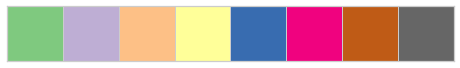

In [16]:
#Set themes
import matplotlib.pyplot as plt
#plot
sns.set()
sns.set_context("talk") #In order of relative size they are: paper, notebook, talk, and poster. Notebook is default
sns.set(style="whitegrid") #Seaborn has five built-in themes to style its plots: darkgrid, whitegrid, dark, white, and ticks. 
# Save a palette to a variable:
palette = sns.color_palette("Accent",8)
# Use palplot and pass in the variable:
sns.palplot(palette)
# Set the palette using the name of a palette:
sns.set_palette(palette)

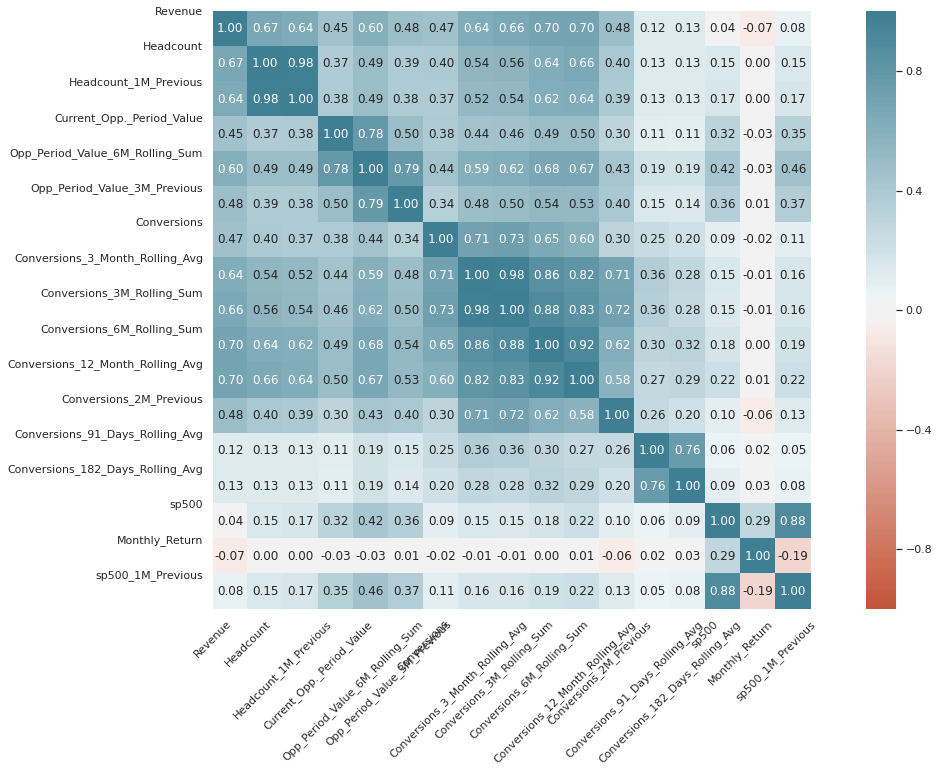

In [17]:
from scipy.stats import pearsonr
import matplotlib.pyplot as plt 
revtime_hist1 = revtime_hist.copy()
#cols = list(revtime_hist1.select_dtypes(include='float64').columns)
coerce_df_columns_to_numeric(revtime_hist1)

#sns.set()  
#cols = list(pipetalentrev_final.select_dtypes(include='integer').columns)
#display(cols)
#g = sns.pairplot(pipetalentrev_final, x_vars = cols, y_vars = 'Revenue', kind="reg", height=3, palette=palette)
#g.map_upper(corrfunc)
#plt.show()
#for col in cols:
#        sns.pairplot(pipetalentrev_final, x_vars = col, y_vars = 'Revenue', kind="reg", height=3, palette=palette)
fig, ax = plt.subplots(figsize=(20,11))
corr = revtime_hist1.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    annot=True,
    square=True,
    fmt=".2f"
)
# Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
# Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='center'
);
plt.show()

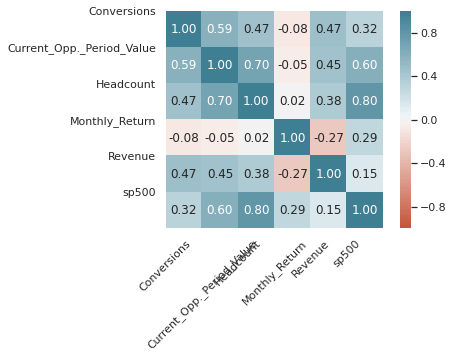

In [18]:
###FINE LAG BETWEEN KEY FEATURES
cols = ['End_of_Month','Studio','Revenue','Conversions','Headcount','Current_Opp._Period_Value','sp500','Monthly_Return']
revtime_hist11 = revtime_hist1.pivot_table(index=['End_of_Month'], values=cols[2:], aggfunc=np.sum, fill_value=0)
#revtime_hist11 = revtime_hist11.reset_index(level=revtime_hist11.index.names)
#display(revtime_hist11)
corr = revtime_hist11.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    annot=True,
    square=True,
    fmt=".2f"
)
# Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
# Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='center'
);
plt.show()

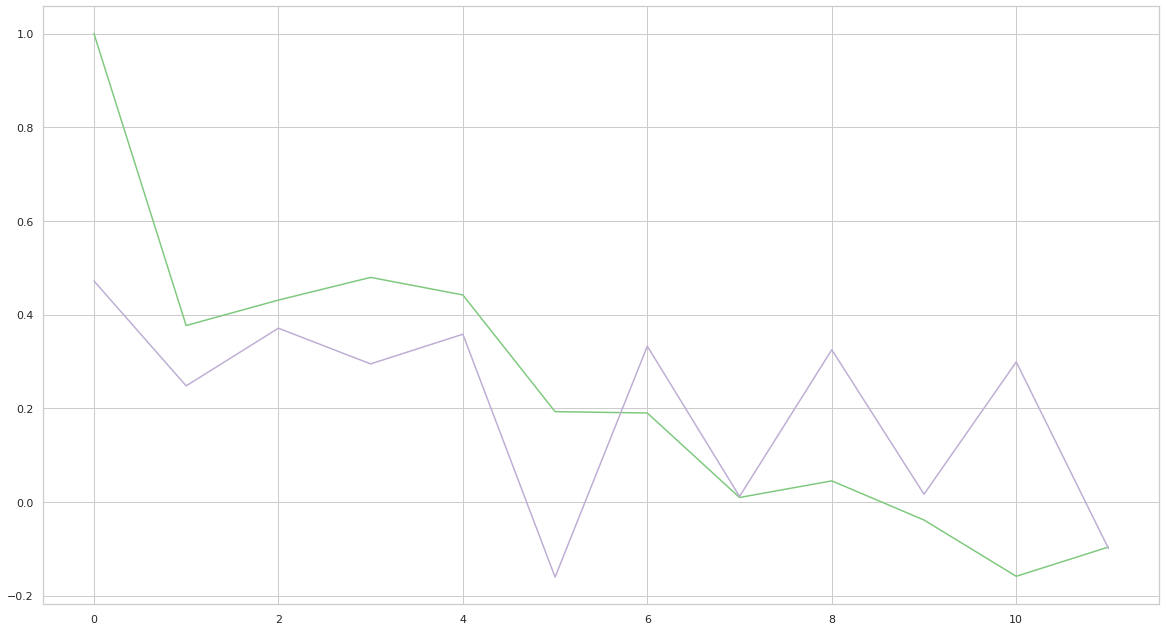

In [19]:
fig, ax = plt.subplots(figsize=(20,11))
def crosscorr(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))
datax = revtime_hist11['Revenue']
datay = revtime_hist11['Revenue']
xcov_monthly_revenue = [crosscorr(datax, datay, lag=i) for i in range(12)]
plt.plot(xcov_monthly_revenue)
datay = revtime_hist11['Conversions']
xcov_monthly_conversions = [crosscorr(datax, datay, lag=i) for i in range(12)]
plt.plot(xcov_monthly_conversions)
datay = revtime_hist11['Current_Opp._Period_Value']
xcov_monthly_opp_period = [crosscorr(datax, datay, lag=i) for i in range(12)]
#plt.plot(xcov_monthly_opp_period)
datay = revtime_hist11['Headcount']
xcov_monthly_hc = [crosscorr(datax, datay, lag=i) for i in range(12)]
#plt.plot(xcov_monthly_hc)
datay = revtime_hist11['sp500']
xcov_monthly_hc = [crosscorr(datax, datay, lag=i) for i in range(12)]
#plt.plot(xcov_monthly_hc)

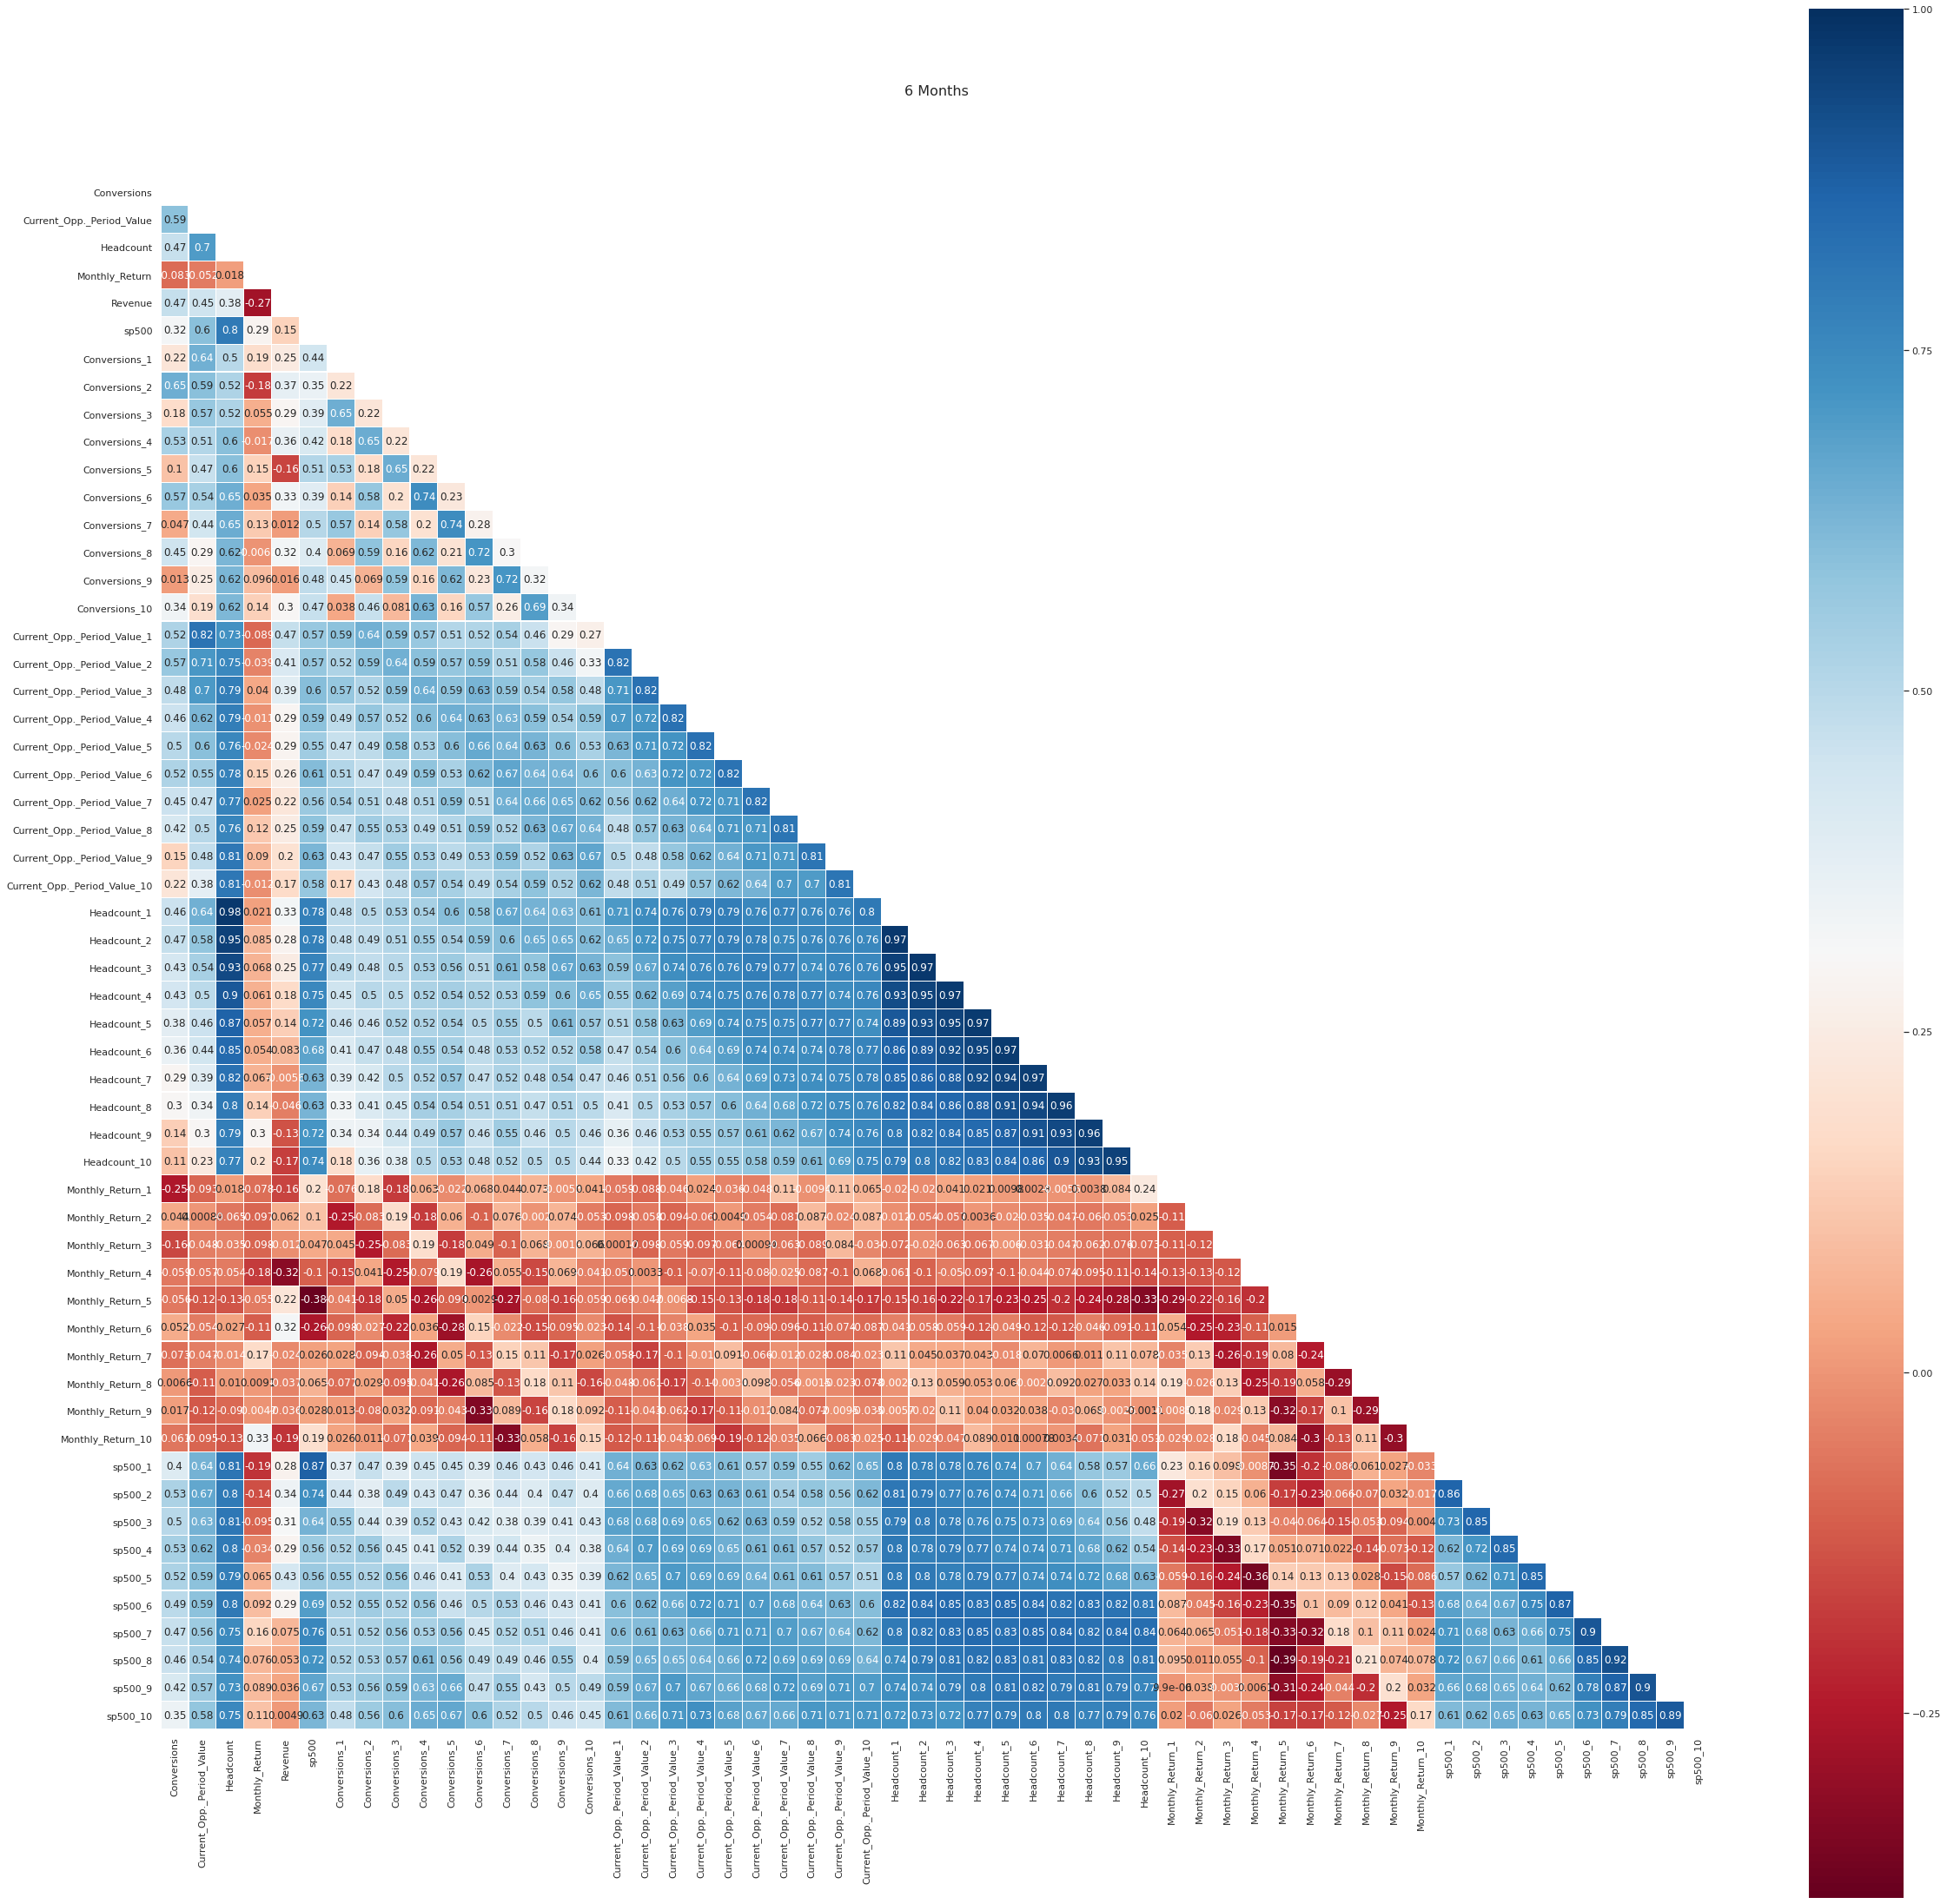

In [20]:
# Cross-correlation (time-lag) with pandas
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
    return df
NON_DER = ['Revenue',]
df_new = df_derived_by_shift(revtime_hist11, 10, NON_DER)
colormap = plt.cm.RdBu
plt.figure(figsize=(40,40))
plt.title(u'6 Months', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

AttributeError: 'Index' object has no attribute 'to_list'

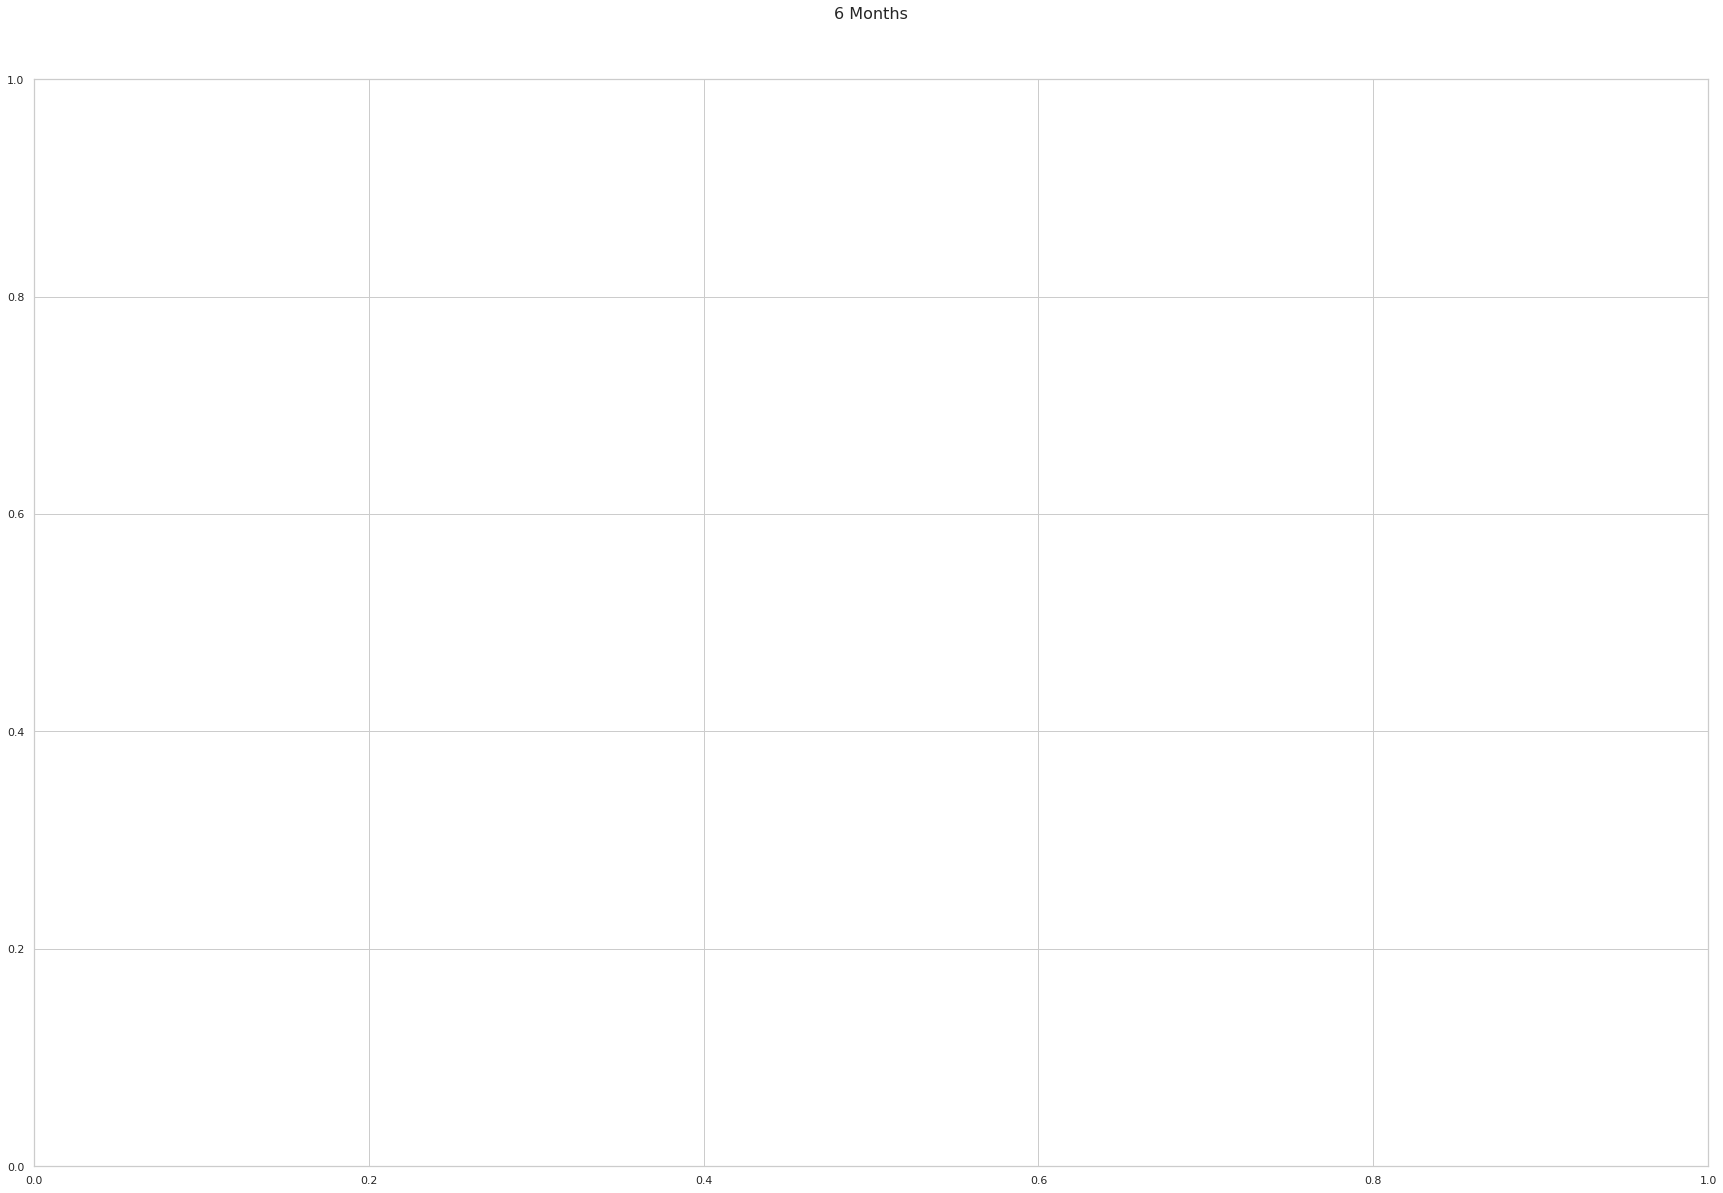

In [21]:
#Only Sig, Correlations
from scipy import stats
plt.figure(figsize=(30,20))
plt.title(u'6 Months', y=1.05, size=16)
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            _ , p = stats.pearsonr(df[col],df[col2])
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p
    return p_matrix
def plot_cor_matrix(corr, mask=None):
    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(corr, ax=ax,
                mask=mask,
                # cosmetics
                annot=True, vmin=-1, vmax=1, center=0,
                cmap='coolwarm', linewidths=2, linecolor='black', cbar_kws={'orientation': 'horizontal'})
p_values = corr_sig(df_new)            # get p-Value
mask = np.invert(np.tril(p_values<0.05))    # mask - only get significant corr

plot_cor_matrix(df_new,mask)  

In [22]:
from scipy.stats import pearsonr
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x)

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
            if (pvalues[r][c] <= 0.0500):
                pvalues[r][c] = pvalues[r][c]
            else:
                pvalues[r][c] = -1
    return pvalues
pvalues = calculate_pvalues(df_new)
pvalues['Revenue']

Conversions                    0.0158
Current_Opp._Period_Value       -1   
Headcount                       -1   
Monthly_Return                  -1   
Revenue                        0.0000
sp500                           -1   
Conversions_1                   -1   
Conversions_2                   -1   
Conversions_3                   -1   
Conversions_4                   -1   
Conversions_5                   -1   
Conversions_6                   -1   
Conversions_7                   -1   
Conversions_8                   -1   
Conversions_9                   -1   
Conversions_10                  -1   
Current_Opp._Period_Value_1    0.0277
Current_Opp._Period_Value_2     -1   
Current_Opp._Period_Value_3     -1   
Current_Opp._Period_Value_4     -1   
Current_Opp._Period_Value_5     -1   
Current_Opp._Period_Value_6     -1   
Current_Opp._Period_Value_7     -1   
Current_Opp._Period_Value_8     -1   
Current_Opp._Period_Value_9     -1   
Current_Opp._Period_Value_10    -1   
Headcount_1 

In [23]:
#concat df_new and pvalues, then filter for significant pvalues 

corr_values = df_new.corr()#.append(pvalues)
cross_ref = pd.concat([corr_values['Revenue'], pvalues['Revenue']], axis=1)
display(cross_ref)


,Revenue,Revenue
Conversions,0.4718,0.0158
Current_Opp._Period_Value,0.4494,-1
Headcount,0.3798,-1
Monthly_Return,-0.2732,-1
Revenue,1.0000,0.0000
sp500,0.1482,-1
Conversions_1,0.2477,-1
Conversions_2,0.3708,-1
Conversions_3,0.2946,-1
Conversions_4,0.3579,-1


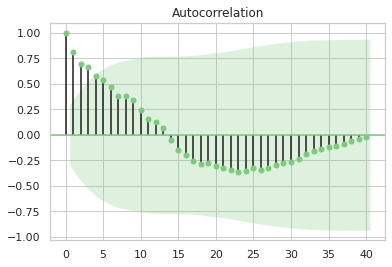

In [24]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(revtime_hist11['Current_Opp._Period_Value'].values.squeeze(), lags=40)
plt.show()

[ 9335153  9173656 11264470  9544445 10408480  9902796  8403188  9871625
  9641560  9185371  9452926  7962863 10357456  9047620 11505170 11794177
 12584620 11526625 11225377 11883769 11310855 12998286 11493054 10050672
 11630463 11274227 12713278 12283082 12939435 11577146 13944827 12922548
 14214303 15385087 13908536 13212290 14184237 13088781 14219487 10341767
 10046490 11794191 13230618    27694]
[10541476  7357435  8864803  5176597  6739961  4098409 10926564  4705173
  3713509  3887004  2628205  3802816  8757113  4530794  8207778  8538792
  8436856 13239457 15940600 10165549 12571307 10262327 11302448  9575818
 19832500 12408946 21541204  7337935 14570706 12670028 14655554  8962590
 15568622  8864879 17634583  9809027 18459264  8915548 24334585 11353821
  9378559 10187745 11823466  9084647]


/anaconda/envs/azureml_py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:2020: RuntimeWarning: overflow encountered in long_scalars
  correls /= np.sqrt(np.dot(x, x) * np.dot(y, y))


TypeError: ufunc 'true_divide' output (typecode 'd') could not be coerced to provided output parameter (typecode 'l') according to the casting rule ''same_kind''

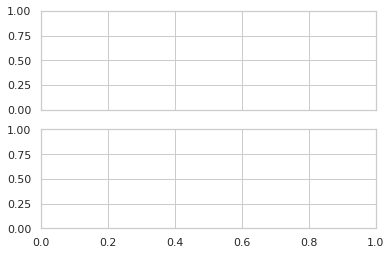

In [25]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

fig, [ax1, ax2] = plt.subplots(2, 1, sharex=True)
cols = ['Revenue','Conversions','Headcount','Current_Opp._Period_Value']

x = df_new['Revenue'].reset_index(drop=True).values
y = df_new['Conversions'].reset_index(drop=True).values

print(x)
print(y)
ax1.xcorr(x, y, normed=True, 
          usevlines=True,          
          maxlags=10,            
          lw=2)
ax1.grid(True)

ax2.acorr(x, normed=True, 
          usevlines=True, 
          maxlags=10, 
          lw=2)
ax2.grid(True)

plt.show()

In [26]:
#def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
#    r, _ = pearsonr(x, y)
#    ax = ax or plt.gca()
#    # Unicode for lowercase rho (ρ)
#    rho = '\u03C1'
#    ax.annotate(f'{rho} = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)
    
#filter_col = [col for col in pipetalentrev_final if col.startswith('Pipeline-')]
#list(filter_col)
#g = sns.pairplot(revtime_hist1, 
#                 kind="reg", 
#                 height=5, 
#                 palette=palette)
#g.map_upper(corrfunc)
#plt.show()

'Plot the correlation coefficient in the top left hand corner of a plot.'

In [27]:
###########################################################################################
##### Process Steps after RevTime forecast is run - "revpipe-dataprep"
#Merge revtime_hist2 with merge_df
revtime_hist2 = pd.read_csv("revtime_hist2.csv")
revtime_hist2['End_of_Month'] = pd.to_datetime(revtime_hist2['End_of_Month'])
#show_stats(revtime_hist2)
cols = ['End_of_Month','Studio','Revenue_Forecast']
merge_df1 = revtime_hist2[cols].reset_index(drop=True)
#merge_df1 = pd.merge(merge_df, revtime_hist2[cols], how='left', on=['End_of_Month','Studio']).fillna(nan_value)
coerce_df_columns_to_numeric(merge_df1)
merge_df1 = merge_df1.replace(np.nan, 0, regex=True)
merge_df1.sort_values(by=['End_of_Month','Studio']).reset_index(drop=True)
#merge_df1.drop(columns=['Revenue'], axis=1, inplace = True)
merge_df1['Revenue'] = merge_df1['Revenue_Forecast']
merge_df1.drop(columns=['Revenue_Forecast'], axis=1, inplace = True)
#merge_df.drop(columns=['Current_Opp._Period_Value','Conversions'], axis=1, inplace = True)
print("\n merge_df1: \n")
#merge_df.to_csv("merge_df1.csv", index=False)
show_stats(merge_df1)
merge_df1.query('Studio==@studio_debug')


 merge_df1: 


 DF Name: 



'merge_df1'


 DF Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 3 columns):
End_of_Month    850 non-null datetime64[ns]
Studio          850 non-null object
Revenue         850 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 20.0+ KB


None


 DF Describe: 



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
End_of_Month,850,50,2017-12-31 00:00:00,17,2017-01-31 00:00:00,2021-02-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Studio,850,17,SF OS,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenue,850.0000,NaN,NaN,NaN,NaN,NaN,668994.2718,569814.0463,0.0000,214706.2500,591442.0000,928567.0000,3096421.0000



 DF Head: 



,End_of_Month,Studio,Revenue
0,2017-01-31,Cambridge,1384053
1,2017-01-31,Chicago,1236187
2,2017-01-31,Creative Leadership,0
3,2017-01-31,D4C,1140432
4,2017-01-31,D4L,601459



 DF Tail: 



,End_of_Month,Studio,Revenue
845,2021-02-28,SF OS,305579
846,2021-02-28,Shanghai,452323
847,2021-02-28,Super,2503496
848,2021-02-28,Teachers Guild,37925
849,2021-02-28,Tokyo,482950



 Studio Sum: 



,Studio,Revenue
0,Cambridge,59501679
1,Chicago,82136145
2,Creative Leadership,864119
3,D4C,51472543
4,D4L,31157461



 Studio Count: 



,Studio,End_of_Month,Revenue
0,Cambridge,50,50
1,Chicago,50,50
2,Creative Leadership,50,50
3,D4C,50,50
4,D4L,50,50



 EOM Sum:


,End_of_Month,Revenue
0,2017-01-31,9335153
1,2017-02-28,9173656
2,2017-03-31,11264470
3,2017-04-30,9544445
4,2017-05-31,10408480



 EOM Count: 



,End_of_Month,Studio,Revenue
0,2017-01-31,17,17
1,2017-02-28,17,17
2,2017-03-31,17,17
3,2017-04-30,17,17
4,2017-05-31,17,17


,End_of_Month,Studio,Revenue
8,2017-01-31,London,640653
25,2017-02-28,London,686520
42,2017-03-31,London,695914
59,2017-04-30,London,620690
76,2017-05-31,London,480997
93,2017-06-30,London,613119
110,2017-07-31,London,924330
127,2017-08-31,London,652908
144,2017-09-30,London,906711
161,2017-10-31,London,813818


In [28]:
#Process Pipeline History

print("\n pipehist1: \n")
print(pipehist1.query('Studio==@studio_debug'))
#pivot
pipehist_pivot = pipehist1.pivot_table(index='End_of_Month', columns='Studio', values='Pipeline', aggfunc='count', margins=False)
pipehist_pivot = pipehist_pivot.reset_index(level=pipehist_pivot.index.names)


 pipehist1: 

      Snapshot_Date_Short  Relative_Snapshot_Month_Offset End_of_Month  Relative_Month_Offset  Studio  Pipeline  Active_Unrecognized_Revenue  Opportunity_Revenue  Pipeline_3_Month_Rolling_Avg  Pipeline_3_Month_Rolling_Sum  Pipeline_MoM  Pipeline_3M_Forward_Sum  Pipeline_3M_Forward_Avg
13    2018-07-31          -25                             2017-01-31   -43                     London  640653    0                            0                    4267293                       8534587                      -7253280       2023088                  674362                 
31    2018-07-31          -25                             2017-02-28   -42                     London  686520    0                            0                    3073702                       9221108                       45866         2003124                  667708                 
49    2018-07-31          -25                             2017-03-31   -41                     London  695914    0             

In [29]:
#pipetrend_pivot1 = pipetrend1.pivot_table(index=['Snapshot_Date_Short','Relative_Snapshot_Month_Offset','Studio'], 
#                                          columns='Pipeline_Type', values='Pipeline_Trend', aggfunc=np.sum)#, fill_value=0)
#coerce_df_columns_to_numeric(pipetrend_pivot1, ['Active_Unrecognized','Opportunity','Opportunity_ML'])
#pipetrend_pivot1 = pipetrend_pivot1.reset_index(level=pipetrend_pivot1.index.names)
#pipetrend_pivot1['Snapshot_Date_Short'] = pd.to_datetime(pipetrend_pivot1['Snapshot_Date_Short']) 
#print("\n pipetrend_pivot1: \n")
#show_stats(pipetrend_pivot1)
#print(pipetrend_pivot1.query('Studio==@studio_debug'))

In [30]:
#Calculate pipeline month offset for corresponding snapshot dates
pipehist_long = pipehist1.copy()
pipehist_long["Relative_Offset"] = (pipehist_long['Relative_Snapshot_Month_Offset'] - pipehist_long['Relative_Month_Offset'])
#pipehist2 = pipehist2.query('Relative_Offset>=-11 and Relative_Offset<=0')
pipehist_long["Relative_Offset"] = pipehist_long["Relative_Offset"].astype(str).str.zfill(3)
pipehist_long["Relative_Offset"] = pipehist_long["Relative_Offset"].str.replace("000","-00")
pipehist_long["Relative_Offset"] = "Relative" + pipehist_long["Relative_Offset"].str.replace("0-","-0")
pipehist_long.sort_values(by=['Snapshot_Date_Short','End_of_Month','Studio']).reset_index(drop=True)
print("\n pipehist_long: \n")
#pipehist_long.to_csv("pipehist_long.csv", index=False)
print(pipehist_long.query('Studio==@studio_debug'))
show_stats(pipehist_long)


 pipehist_long: 

      Snapshot_Date_Short  Relative_Snapshot_Month_Offset End_of_Month  Relative_Month_Offset  Studio  Pipeline  Active_Unrecognized_Revenue  Opportunity_Revenue  Pipeline_3_Month_Rolling_Avg  Pipeline_3_Month_Rolling_Sum  Pipeline_MoM  Pipeline_3M_Forward_Sum  Pipeline_3M_Forward_Avg Relative_Offset
13    2018-07-31          -25                             2017-01-31   -43                     London  640653    0                            0                    4267293                       8534587                      -7253280       2023088                  674362                   Relative018   
31    2018-07-31          -25                             2017-02-28   -42                     London  686520    0                            0                    3073702                       9221108                       45866         2003124                  667708                   Relative017   
49    2018-07-31          -25                             2017-03-31   -41 

'pipehist_long'


 DF Info: 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17548 entries, 0 to 19739
Data columns (total 14 columns):
Snapshot_Date_Short               17548 non-null datetime64[ns]
Relative_Snapshot_Month_Offset    17548 non-null int64
End_of_Month                      17548 non-null datetime64[ns]
Relative_Month_Offset             17548 non-null int64
Studio                            17548 non-null object
Pipeline                          17548 non-null int64
Active_Unrecognized_Revenue       17548 non-null int64
Opportunity_Revenue               17548 non-null int64
Pipeline_3_Month_Rolling_Avg      17548 non-null int64
Pipeline_3_Month_Rolling_Sum      17548 non-null int64
Pipeline_MoM                      17548 non-null int64
Pipeline_3M_Forward_Sum           17548 non-null int64
Pipeline_3M_Forward_Avg           17548 non-null int64
Relative_Offset                   17548 non-null object
dtypes: datetime64[ns](2), int64(10), object(2)
memory usage: 2.0+ MB


None


 DF Describe: 



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date_Short,17548,26,2020-08-31 00:00:00,864,2018-07-31 00:00:00,2020-08-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Snapshot_Month_Offset,17548.0000,NaN,NaN,NaN,NaN,NaN,-11.0169,7.3029,-25.0000,-17.0000,-10.0000,-5.0000,0.0000
End_of_Month,17548,55,2018-11-30 00:00:00,409,2017-01-31 00:00:00,2021-07-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Month_Offset,17548.0000,NaN,NaN,NaN,NaN,NaN,-20.5369,13.8203,-43.0000,-32.0000,-21.0000,-10.0000,11.0000
Studio,17548,17,Cambridge,1230,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



 DF Head: 



,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Studio,Pipeline,Active_Unrecognized_Revenue,Opportunity_Revenue,Pipeline_3_Month_Rolling_Avg,Pipeline_3_Month_Rolling_Sum,Pipeline_MoM,Pipeline_3M_Forward_Sum,Pipeline_3M_Forward_Avg,Relative_Offset
0,2018-07-31,-25,2017-01-31,-43,Global,54366,0,0,586756,1173513,-1064779,181766,60588,Relative018
3,2018-07-31,-25,2017-01-31,-43,SF OS,238538,0,0,1463127,2926255,-2449179,585210,195070,Relative018
4,2018-07-31,-25,2017-01-31,-43,D4L,601459,0,0,4108763,8217526,-7014607,1904967,634989,Relative018
5,2018-07-31,-25,2017-01-31,-43,Food,365722,0,0,2843832,5687664,-4956219,1462912,487637,Relative018
6,2018-07-31,-25,2017-01-31,-43,Super,1003829,0,0,7803664,15607329,-13599669,3366484,1122161,Relative018



 DF Tail: 



,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Studio,Pipeline,Active_Unrecognized_Revenue,Opportunity_Revenue,Pipeline_3_Month_Rolling_Avg,Pipeline_3_Month_Rolling_Sum,Pipeline_MoM,Pipeline_3M_Forward_Sum,Pipeline_3M_Forward_Avg,Relative_Offset
19735,2020-08-31,0,2021-07-31,11,Cambridge,80397,0,80397,87303,261911,-612,241191,80397,Relative-11
19736,2020-08-31,0,2021-07-31,11,Chicago,0,0,0,19934,39868,-2727,0,0,Relative-11
19737,2020-08-31,0,2021-07-31,11,New York,0,0,0,32573,65146,-27182,0,0,Relative-11
19738,2020-08-31,0,2021-07-31,11,Shanghai,0,0,0,5178,10357,-900,0,0,Relative-11
19739,2020-08-31,0,2021-07-31,11,Tokyo,0,0,0,13863,13863,0,0,0,Relative-11



 Studio Sum: 



,Studio,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline,Active_Unrecognized_Revenue,Opportunity_Revenue,Pipeline_3_Month_Rolling_Avg,Pipeline_3_Month_Rolling_Sum,Pipeline_MoM,Pipeline_3M_Forward_Sum,Pipeline_3M_Forward_Avg
0,Cambridge,-14035,-23664,1157905893,94529680,90502411,1468309941,4202783208,-364860789,3368065948,1123163836
1,Chicago,-13455,-23438,1563386257,148847226,120285242,1835336032,5326177147,-318179874,4596346237,1533619712
2,Creative Leadership,-2767,-4019,11325184,3010850,762266,12152213,33424749,7,33424749,12152213
3,D4C,-13055,-23881,1000871164,102809507,77549388,1245714831,3575058593,-286337087,2917076178,973779593
4,D4L,-12255,-23739,606966300,40444440,44621328,775782806,2216935463,-198017623,1774329535,592638234



 Studio Count: 



,Studio,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Active_Unrecognized_Revenue,Opportunity_Revenue,Pipeline_3_Month_Rolling_Avg,Pipeline_3_Month_Rolling_Sum,Pipeline_MoM,Pipeline_3M_Forward_Sum,Pipeline_3M_Forward_Avg,Relative_Offset
0,Cambridge,1230,1230,1230,1230,1230,1230,1230,1230,1230,1230,1230,1230,1230
1,Chicago,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200,1200
2,Creative Leadership,374,374,374,374,374,374,374,374,374,374,374,374,374
3,D4C,1156,1156,1156,1156,1156,1156,1156,1156,1156,1156,1156,1156,1156
4,D4L,1103,1103,1103,1103,1103,1103,1103,1103,1103,1103,1103,1103,1103



 EOM Sum:


,End_of_Month,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline,Active_Unrecognized_Revenue,Opportunity_Revenue,Pipeline_3_Month_Rolling_Avg,Pipeline_3_Month_Rolling_Sum,Pipeline_MoM,Pipeline_3M_Forward_Sum,Pipeline_3M_Forward_Avg
0,2017-01-31,-4875,-16770,242713978,0,0,1485476462,2970953234,-2485524914,774105564,258704082
1,2017-02-28,-4875,-16380,238515032,0,0,1069879074,3209468472,-4198818,779547134,259848966
2,2017-03-31,-4875,-15990,292876244,0,0,258704082,774105564,54361084,811652634,270550750
3,2017-04-30,-4875,-15600,248155522,0,0,259848966,779547134,-44720668,776156966,258718826
4,2017-05-31,-4875,-15210,270620528,0,0,270550750,811652634,22464978,746484408,248827980



 EOM Count: 



,End_of_Month,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Studio,Pipeline,Active_Unrecognized_Revenue,Opportunity_Revenue,Pipeline_3_Month_Rolling_Avg,Pipeline_3_Month_Rolling_Sum,Pipeline_MoM,Pipeline_3M_Forward_Sum,Pipeline_3M_Forward_Avg,Relative_Offset
0,2017-01-31,390,390,390,390,390,390,390,390,390,390,390,390,390
1,2017-02-28,390,390,390,390,390,390,390,390,390,390,390,390,390
2,2017-03-31,390,390,390,390,390,390,390,390,390,390,390,390,390
3,2017-04-30,390,390,390,390,390,390,390,390,390,390,390,390,390
4,2017-05-31,390,390,390,390,390,390,390,390,390,390,390,390,390



 SDS Sum:


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline,Active_Unrecognized_Revenue,Opportunity_Revenue,Pipeline_3_Month_Rolling_Avg,Pipeline_3_Month_Rolling_Sum,Pipeline_MoM,Pipeline_3M_Forward_Sum,Pipeline_3M_Forward_Avg
0,2018-07-31,-11950,-12792,245961683,34751395,30248054,335247566,946062470,-104908049,708058921,236866318
1,2018-08-31,-11472,-12793,258672007,33250000,33224067,348478167,984103685,-104907813,746190600,250127073
2,2018-09-30,-10488,-12843,269797460,34618114,31072853,359500522,1017553378,-104932242,779493634,261100545
3,2018-10-31,-10648,-13141,270673950,33976779,21277432,360210618,1020182855,-104932236,782123111,261810641
4,2018-11-30,-10395,-13263,289615241,27994318,33197520,379236747,1076383098,-104932227,837386731,280524563



 SDS Count: 



,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Studio,Pipeline,Active_Unrecognized_Revenue,Opportunity_Revenue,Pipeline_3_Month_Rolling_Avg,Pipeline_3_Month_Rolling_Sum,Pipeline_MoM,Pipeline_3M_Forward_Sum,Pipeline_3M_Forward_Avg,Relative_Offset
0,2018-07-31,478,478,478,478,478,478,478,478,478,478,478,478,478
1,2018-08-31,478,478,478,478,478,478,478,478,478,478,478,478,478
2,2018-09-30,456,456,456,456,456,456,456,456,456,456,456,456,456
3,2018-10-31,484,484,484,484,484,484,484,484,484,484,484,484,484
4,2018-11-30,495,495,495,495,495,495,495,495,495,495,495,495,495


In [31]:
# Merge merge_df with Pipeline Long History 
pipe_offset = ['Relative-00','Relative-01','Relative-02','Relative-03',
               'Relative-04','Relative-05','Relative-06'
#               ,'Relative-07', 'Relative-08','Relative-09','Relative-10','Relative-11'
              ]
revpipe_final = pd.merge(pipehist_long, merge_df1, how='left', on=['End_of_Month','Studio'])
#revpipe_final['End_of_Month'] = pd.to_datetime(revpipe_final['End_of_Month'])
#revpipe_final['Snapshot_Date_Short'] = pd.to_datetime(revpipe_final['Snapshot_Date_Short'])
#revpipe_final['Relative_Month_Offset'] = round((revpipe_final['End_of_Month'] - current_eom)/np.timedelta64(1,'M'),0)
coerce_df_columns_to_numeric(revpipe_final)
# Filter for only next 11 months rows w.r.t. to snapshot date
revpipe_final1 = revpipe_final.query('Relative_Offset in @pipe_offset').reset_index(drop=True)
#revpipe_final = revpipe_final1.replace(np.nan, 0, regex=True)
revpipe_final1 = revpipe_final1.sort_values(by=['Snapshot_Date_Short','End_of_Month','Studio']).reset_index(drop=True)
print("\n revpipe_final1: \n")
revpipe_final1.to_csv("revpipe_final.csv", index=False)
show_stats(revpipe_final1)
revpipe_final1.query('Studio==@studio_debug')


 revpipe_final1: 


 DF Name: 



'revpipe_final1'


 DF Info: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2932 entries, 0 to 2931
Data columns (total 15 columns):
Snapshot_Date_Short               2932 non-null datetime64[ns]
Relative_Snapshot_Month_Offset    2932 non-null int64
End_of_Month                      2932 non-null datetime64[ns]
Relative_Month_Offset             2932 non-null int64
Studio                            2932 non-null object
Pipeline                          2932 non-null int64
Active_Unrecognized_Revenue       2932 non-null int64
Opportunity_Revenue               2932 non-null int64
Pipeline_3_Month_Rolling_Avg      2932 non-null int64
Pipeline_3_Month_Rolling_Sum      2932 non-null int64
Pipeline_MoM                      2932 non-null int64
Pipeline_3M_Forward_Sum           2932 non-null int64
Pipeline_3M_Forward_Avg           2932 non-null int64
Relative_Offset                   2932 non-null object
Revenue                           2932 non-null int64
dtypes: datetime64[ns](2), int64(11), object(2)
me

None


 DF Describe: 



,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Snapshot_Date_Short,2932,26,2020-01-31 00:00:00,119,2018-07-31 00:00:00,2020-08-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Snapshot_Month_Offset,2932.0000,NaN,NaN,NaN,NaN,NaN,-12.1712,7.4177,-25.0000,-18.0000,-12.0000,-6.0000,0.0000
End_of_Month,2932,32,2020-07-31 00:00:00,119,2018-07-31 00:00:00,2021-02-28 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relative_Month_Offset,2932.0000,NaN,NaN,NaN,NaN,NaN,-9.1988,7.6781,-25.0000,-16.0000,-9.0000,-3.0000,6.0000
Studio,2932,17,Shanghai,182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



 DF Head: 



,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Studio,Pipeline,Active_Unrecognized_Revenue,Opportunity_Revenue,Pipeline_3_Month_Rolling_Avg,Pipeline_3_Month_Rolling_Sum,Pipeline_MoM,Pipeline_3M_Forward_Sum,Pipeline_3M_Forward_Avg,Relative_Offset,Revenue
0,2018-07-31,-25,2018-07-31,-25,Cambridge,1204028,1190091,13937,1290427,3871282,-122730,4598863,1532954,Relative-00,1167320
1,2018-07-31,-25,2018-07-31,-25,Chicago,1727025,1727025,0,1925101,5775305,-196920,6254188,2084729,Relative-00,1471901
2,2018-07-31,-25,2018-07-31,-25,D4C,1449893,1449893,0,1450284,4350854,-43844,4649230,1549743,Relative-00,1355137
3,2018-07-31,-25,2018-07-31,-25,D4L,508838,508838,0,573807,1721423,-96082,1906705,635568,Relative-00,526425
4,2018-07-31,-25,2018-07-31,-25,Food,454369,454369,0,656938,1970816,-271108,1520891,506963,Relative-00,446128



 DF Tail: 



,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Studio,Pipeline,Active_Unrecognized_Revenue,Opportunity_Revenue,Pipeline_3_Month_Rolling_Avg,Pipeline_3_Month_Rolling_Sum,Pipeline_MoM,Pipeline_3M_Forward_Sum,Pipeline_3M_Forward_Avg,Relative_Offset,Revenue
2927,2020-08-31,0,2021-02-28,6,OpenIDEO,308732,207775,100956,314368,943104,-86982,962660,320886,Relative-06,193473
2928,2020-08-31,0,2021-02-28,6,SF OS,36059,36059,0,45696,137090,-6670,114630,38210,Relative-06,305579
2929,2020-08-31,0,2021-02-28,6,Shanghai,402424,85482,316941,450519,1351558,9522,904741,301580,Relative-06,452323
2930,2020-08-31,0,2021-02-28,6,Super,355084,0,355084,648450,1945350,-586068,908032,302677,Relative-06,2503496
2931,2020-08-31,0,2021-02-28,6,Tokyo,244179,0,244179,274208,822625,-33682,541244,180414,Relative-06,482950



 Studio Sum: 



,Studio,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline,Active_Unrecognized_Revenue,Opportunity_Revenue,Pipeline_3_Month_Rolling_Avg,Pipeline_3_Month_Rolling_Sum,Pipeline_MoM,Pipeline_3M_Forward_Sum,Pipeline_3M_Forward_Avg,Revenue
0,Cambridge,-2275,-1729,170809225,90609357,80157094,194933614,584801007,-25660076,426439993,142146612,220876560
1,Chicago,-2275,-1729,240506324,144369310,96005776,271924105,815591326,-33399803,603652897,201554122,315992345
2,Creative Leadership,-1088,-731,3741771,2979096,762266,4460629,12716805,-573635,8532298,3203841,4367973
3,D4C,-2275,-1729,161822756,96785938,65117766,182677570,548032921,-21681958,412196130,137465759,197521439
4,D4L,-2275,-1729,80612373,39415828,41196480,93180009,279455576,-13050161,198505317,66480187,111451729



 Studio Count: 



,Studio,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Pipeline,Active_Unrecognized_Revenue,Opportunity_Revenue,Pipeline_3_Month_Rolling_Avg,Pipeline_3_Month_Rolling_Sum,Pipeline_MoM,Pipeline_3M_Forward_Sum,Pipeline_3M_Forward_Avg,Relative_Offset,Revenue
0,Cambridge,182,182,182,182,182,182,182,182,182,182,182,182,182,182
1,Chicago,182,182,182,182,182,182,182,182,182,182,182,182,182,182
2,Creative Leadership,125,125,125,125,125,125,125,125,125,125,125,125,125,125
3,D4C,182,182,182,182,182,182,182,182,182,182,182,182,182,182
4,D4L,182,182,182,182,182,182,182,182,182,182,182,182,182,182



 EOM Sum:


,End_of_Month,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline,Active_Unrecognized_Revenue,Opportunity_Revenue,Pipeline_3_Month_Rolling_Avg,Pipeline_3_Month_Rolling_Sum,Pipeline_MoM,Pipeline_3M_Forward_Sum,Pipeline_3M_Forward_Avg,Revenue
0,2018-07-31,-375,-375,10896340,10844228,52109,11596613,34789855,-630285,36072437,12024141,11225377
1,2018-08-31,-735,-720,24361406,20947220,3414181,23182232,69546730,2229364,80284725,26761564,23767538
2,2018-09-30,-1080,-1035,36657197,25991616,10640787,35423371,106270158,412025,121426044,40560624,33932565
3,2018-10-31,-1410,-1320,60645816,35262957,25355582,52247574,156742778,12677833,144086451,48169546,51993144
4,2018-11-30,-1725,-1575,61512834,32231688,29248488,64822951,194213059,-11611159,135497242,45187333,57465270



 EOM Count: 



,End_of_Month,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Studio,Pipeline,Active_Unrecognized_Revenue,Opportunity_Revenue,Pipeline_3_Month_Rolling_Avg,Pipeline_3_Month_Rolling_Sum,Pipeline_MoM,Pipeline_3M_Forward_Sum,Pipeline_3M_Forward_Avg,Relative_Offset,Revenue
0,2018-07-31,15,15,15,15,15,15,15,15,15,15,15,15,15,15
1,2018-08-31,30,30,30,30,30,30,30,30,30,30,30,30,30,30
2,2018-09-30,45,45,45,45,45,45,45,45,45,45,45,45,45,45
3,2018-10-31,60,60,60,60,60,60,60,60,60,60,60,60,60,60
4,2018-11-30,75,75,75,75,75,75,75,75,75,75,75,75,75,75



 SDS Sum:


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,Relative_Month_Offset,Pipeline,Active_Unrecognized_Revenue,Opportunity_Revenue,Pipeline_3_Month_Rolling_Avg,Pipeline_3_Month_Rolling_Sum,Pipeline_MoM,Pipeline_3M_Forward_Sum,Pipeline_3M_Forward_Avg,Revenue
0,2018-07-31,-2600,-2291,62541094,34196036,28345026,72224380,215995127,-9980367,155166892,52147169,80362677
1,2018-08-31,-2520,-2205,64521880,32984599,31537249,75103499,224446761,-10534174,158645026,53521459,80601571
2,2018-09-30,-2415,-2100,64923311,34492742,30405756,75375422,224358331,-10481405,156083062,53149155,81400244
3,2018-10-31,-2266,-1963,53202898,33955056,19220561,63993180,190249111,-10406662,122332825,41472066,82252270
4,2018-11-30,-2142,-1844,58576532,27946435,30597440,68292548,203478648,-10177099,146419099,49659401,82085957



 SDS Count: 



,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Studio,Pipeline,Active_Unrecognized_Revenue,Opportunity_Revenue,Pipeline_3_Month_Rolling_Avg,Pipeline_3_Month_Rolling_Sum,Pipeline_MoM,Pipeline_3M_Forward_Sum,Pipeline_3M_Forward_Avg,Relative_Offset,Revenue
0,2018-07-31,104,104,104,104,104,104,104,104,104,104,104,104,104,104
1,2018-08-31,105,105,105,105,105,105,105,105,105,105,105,105,105,105
2,2018-09-30,105,105,105,105,105,105,105,105,105,105,105,105,105,105
3,2018-10-31,103,103,103,103,103,103,103,103,103,103,103,103,103,103
4,2018-11-30,102,102,102,102,102,102,102,102,102,102,102,102,102,102


,Snapshot_Date_Short,Relative_Snapshot_Month_Offset,End_of_Month,Relative_Month_Offset,Studio,Pipeline,Active_Unrecognized_Revenue,Opportunity_Revenue,Pipeline_3_Month_Rolling_Avg,Pipeline_3_Month_Rolling_Sum,Pipeline_MoM,Pipeline_3M_Forward_Sum,Pipeline_3M_Forward_Avg,Relative_Offset,Revenue
6,2018-07-31,-25,2018-07-31,-25,London,933388,933388,0,993873,2981620,-10339,2475730,825243,Relative-00,1078885
21,2018-07-31,-25,2018-08-31,-24,London,749094,709877,39216,875403,2626209,-184293,2279183,759727,Relative-01,911414
36,2018-07-31,-25,2018-09-30,-23,London,793248,505254,287994,825243,2475730,44154,1852439,617479,Relative-02,783017
51,2018-07-31,-25,2018-10-31,-22,London,736840,401486,335354,759727,2279183,-56407,1229098,409699,Relative-03,975430
66,2018-07-31,-25,2018-11-30,-21,London,322349,117491,204858,617479,1852439,-414490,502043,167347,Relative-04,776039
81,2018-07-31,-25,2018-12-31,-20,London,169907,68733,101173,409699,1229098,-152442,179693,89846,Relative-05,773985
95,2018-07-31,-25,2019-01-31,-19,London,9786,0,9786,167347,502043,-160121,9786,9786,Relative-06,818923
110,2018-08-31,-24,2018-08-31,-24,London,784058,784058,0,941520,2824562,-312718,2917484,972494,Relative-00,911414
125,2018-08-31,-24,2018-09-30,-23,London,817091,488513,328578,899308,2697926,33033,2979520,993173,Relative-01,783017
140,2018-08-31,-24,2018-10-31,-22,London,1316334,391283,925050,972494,2917484,499242,2584300,861433,Relative-02,975430


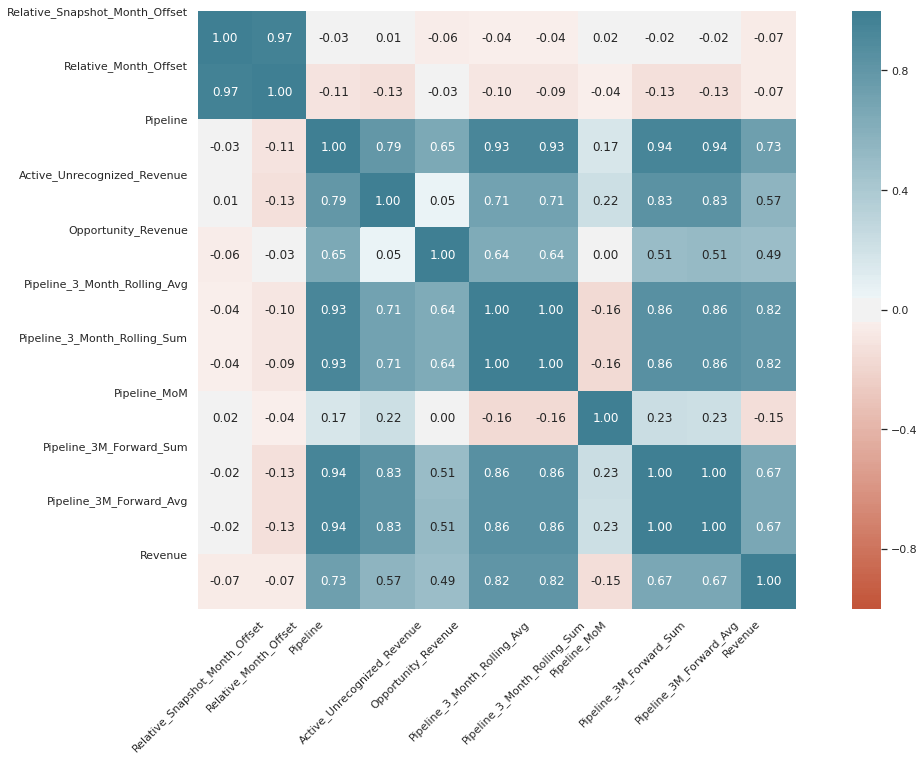

In [32]:
fig, ax = plt.subplots(figsize=(20,11))
corr = revpipe_final1.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    annot=True,
    square=True,
    fmt=".2f"
)
# Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
# Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='center'
);
plt.show()

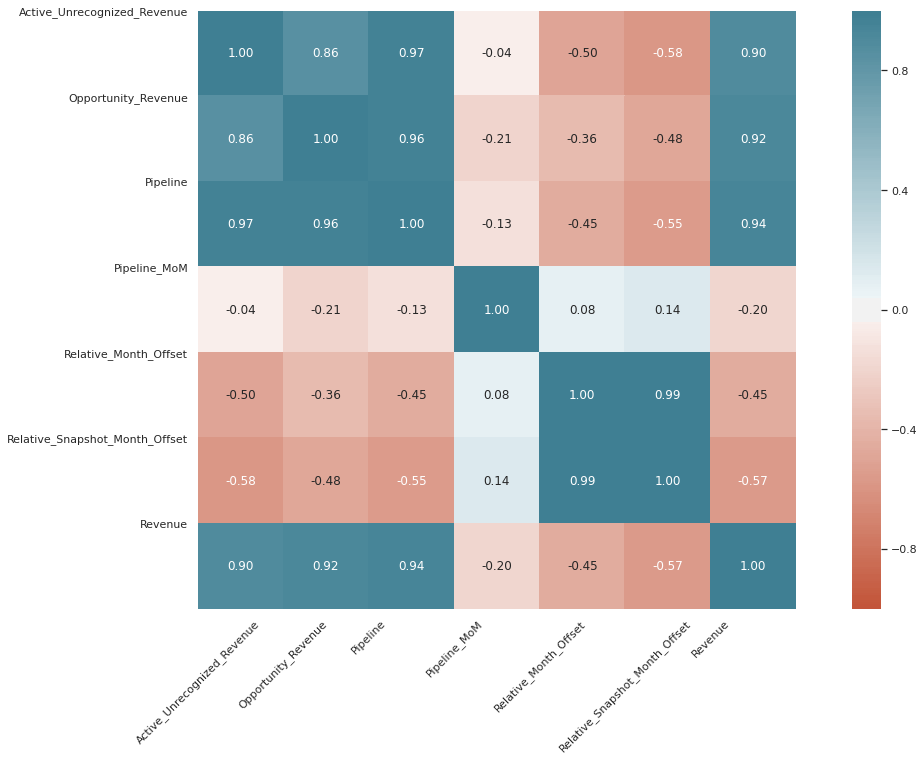

In [33]:
###FINE LAG BETWEEN KEY FEATURES
fig, ax = plt.subplots(figsize=(20,11))
cols = ['Studio','Relative_Snapshot_Month_Offset','Relative_Month_Offset','Revenue','Pipeline','Active_Unrecognized_Revenue','Opportunity_Revenue','Pipeline_MoM']
revpipe_final11 = revpipe_final1.pivot_table(index=['End_of_Month'], values=cols[1:], aggfunc=np.sum, fill_value=0)
#revtime_hist11 = revtime_hist11.reset_index(level=revtime_hist11.index.names)
#display(revtime_hist11)
corr = revpipe_final11.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    annot=True,
    square=True,
    fmt=".2f"
)
# Apply xticks
plt.xticks(range(len(corr.columns)), corr.columns);
# Apply yticks
plt.yticks(range(len(corr.columns)), corr.columns)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='center'
);
plt.show()

In [ ]:
# Cross-correlation (time-lag) with pandas
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
    return df
NON_DER = ['Revenue',]
df_new = df_derived_by_shift(revpipe_final11, 10, NON_DER)
colormap = plt.cm.RdBu
plt.figure(figsize=(50,50))
plt.title(u'6 Months', y=1.05, size=16)

mask = np.zeros_like(df_new.corr())
mask[np.triu_indices_from(mask)] = True

svm = sns.heatmap(df_new.corr(), mask=mask, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [ ]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
    return pvalues
pvalues = calculate_pvalues(df_new)
c1 = df_new.corr()
display(c1)
display(pvalues)

In [ ]:
*******************************************************
END OF PROGRAM

In [ ]:
#EXPORT history and forecast split files
#revhistory = revpipe_final1.query('Relative_Snapshot_Month_Offset < 0').copy()
#revhistory.to_csv("revhistory.csv", index=False)
#print("\n revhistory: \n")
#show_stats(revhistory)

In [ ]:
#revforecast = revpipe_final1.query('Relative_Snapshot_Month_Offset >= 0').copy()
#revforecast.drop(columns=['Revenue'], axis=1, inplace = True)
#revforecast.to_csv("revforecast.csv", index=False)
#print("\n revforecast: \n")
#show_stats(revforecast)

In [ ]:
********************************************************************************
OLD STOP
#Pivot Pipeline
pipe_offset = ['Relative-00','Relative-01','Relative-02','Relative-03',
               'Relative-04','Relative-05','Relative-06','Relative-07',
               'Relative-08','Relative-09','Relative-10','Relative-11'
              ]
pipehist21 = pipehist2.query('(Relative_Offset in  @pipe_offset) or (Relative_Snapshot_Month_Offset == 0 and Relative_Month_Offset > 0)').reset_index(drop=True)
#pipehist2_pivot = pipehist21.copy()
#show_stats(pipehist21)
pipehist2_pivot = pipehist21.pivot_table(index=['End_of_Month','Relative_Month_Offset','Studio'], 
                                    columns='Relative_Offset', 
                                    values='Pipeline', 
                                    aggfunc=np.sum)#, fill_value=0)
cols = list(pipehist2_pivot.select_dtypes(include='float64').columns)
coerce_df_columns_to_numeric(pipehist2_pivot, cols)
pipehist2_pivot = pipehist2_pivot.reset_index(level=pipehist2_pivot.index.names)
pipehist2_pivot['End_of_Month'] = pd.to_datetime(pipehist2_pivot['End_of_Month'])
#pipehist2_pivot['Snapshot_Date_Short'] = pd.to_datetime(pipehist22['Snapshot_Date_Short']) 
print("\n pipehist2_pivot: \n")
show_stats(pipehist2_pivot)
print(pipehist2_pivot.query('Studio==@studio_debug'))

In [ ]:
#Merge pipeline pivot with pipehist2
#pipehist21 = pd.read_csv("../pipehist2.csv")
pipehist22 = pd.merge(pipehist2_pivot, pipehist21.query('(Relative_Offset == "Pipeline-00") or (Relative_Snapshot_Month_Offset == 0 and Relative_Month_Offset >= 0)'), 
                                                        how='left', on=['End_of_Month','Relative_Month_Offset','Studio'])
cols = list(pipehist22.select_dtypes(include='float64').columns)
coerce_df_columns_to_numeric(pipehist22, cols)
pipehist22['End_of_Month'] = pd.to_datetime(pipehist22['End_of_Month'])
pipehist22['Relative_Month_Offset'] = round((pipehist22['End_of_Month'] - current_eom)/np.timedelta64(1,'M'),0)
cols = list(pipehist22.select_dtypes(include='float64').columns)
coerce_df_columns_to_numeric(pipehist22, cols)
pipehist22 = pipehist22.replace(np.nan, 0, regex=True)
pipehist22.sort_values(by=['End_of_Month','Studio']).reset_index(drop=True)
pipehist22 = pipehist22.replace(np.nan, 0, regex=True)
pipehist22.drop(columns=['Snapshot_Date_Short','Relative_Snapshot_Month_Offset','Relative_Offset'], axis=1, inplace = True)
pipehist_pivot = pipehist22.copy()
show_stats(pipehist_pivot)
pipehist_pivot.query('Studio==@studio_debug')


In [ ]:
#convert pivot to dataframe
#remove column names and reset the index for all columns
#pipehist_pivot1 = pipehist_pivot.pivot_table(index=['End_of_Month','Relative_Month_Offset','Studio'], columns='Pipeline_Type', values='Pipeline_6M_Forward_Sum', aggfunc=np.sum, fill_value=0)
#cols = pipehist_pivot1.filter(like='Pipeline', axis=1).columns
#coerce_df_columns_to_numeric(pipehist_pivot1, cols)
#pipehist_pivot1.columns.name=None
#pipehist_pivot1 = pipehist_pivot1.reset_index()
#pipehist_pivot1 = pipehist_pivot1.reset_index(level=pipehist_pivot1.index.names)
pipehist_pivot1 = pipehist_pivot1.reset_index(level=pipehist_pivot1.index.names)
#print("\n pipehist_pivot1: \n")
#pipehist_pivot1[pipehist_pivot1['Studio']=="Creative Leadership"]
#pipehist_pivot1.query('Studio==@studio_debug')

In [ ]:
#Merge with pipelhist_pivot1 to create all the missing months
pipehist4 = pd.merge(pipehist_pivot, eom_studio, how='outer', on=['End_of_Month','Studio'])
#cols = pipehist4.filter(like='Pipeline', axis=1).columns
#coerce_df_columns_to_numeric(pipehist4, cols)

#show_stats(pipehist4)
#pipehist4['Relative_Month_Offset'] = pipehist4['End_of_Month'].dt.to_period('M') - pd.to_datetime('today').to_period('M')
pipehist4['Relative_Month_Offset'] = round((pipehist4['End_of_Month'] - current_eom)/np.timedelta64(1,'M'),0)
cols = list(pipehist4.select_dtypes(include='float64').columns)
#cols = difflist(cols,cols_float)
coerce_df_columns_to_numeric(pipehist4, cols)
#cols = pipehist4.filter(like='Relative_Month_Offset', axis=1).columns
#coerce_df_columns_to_numeric(pipehist4, cols)
pipehist4 = pipehist4.replace(np.nan, 0, regex=True)
pipehist4.sort_values(by=['End_of_Month','Studio']).reset_index(drop=True)
print("\n pipehist4: \n")
#pipehist4.to_csv("pipehist4.csv", index=False)
#pipehist4[pipehist4['Studio']=="Creative Leadership"]
show_stats(pipehist4)
pipehist4.query('Studio==@studio_debug')

In [ ]:
# Merge Pipeline History and Talent History

pipetalent1 = pd.merge(pipehist4, talenthist1, how='left', on=['End_of_Month','Studio'])
cols = list(pipetalent1.select_dtypes(include='float64').columns)
coerce_df_columns_to_numeric(pipetalent1, cols)
pipetalent1 = pipetalent1.query('End_of_Month >= @start_date')
# Replace NAN with 0 and sort by End_of_Month, Studio
pipetalent1 = pipetalent1.replace(np.nan, 0, regex=True)
pipetalent1 = pipetalent1.sort_values(by=['End_of_Month','Studio'])
#pipetalent1.sort_index(inplace=True, axis=1)
print("\n pipetalent1: \n")
show_stats(pipetalent1)
#pipetalent1[pipetalent1['Relative_Month_Offset']==0]
pipetalent1.query('Studio==@studio_debug')

In [ ]:
# Merge PipleineTalent with Revenue History 
pipetalentrev = pd.merge(pipetalent1, revhist1, how='left', on=['End_of_Month','Studio'])
#pipetalentrev['Relative_Month_Offset'] = pipetalentrev['End_of_Month'].dt.to_period('M') - pd.to_datetime('today').to_period('M')
pipetalentrev['Relative_Month_Offset'] = round((pipetalentrev['End_of_Month'] - current_eom)/np.timedelta64(1,'M'),0)
cols = list(pipetalentrev.select_dtypes(include='float64').columns)
coerce_df_columns_to_numeric(pipetalentrev, cols)
pipetalentrev = pipetalentrev.query('End_of_Month >= @start_date')
pipetalentrev = pipetalentrev.replace(np.nan, 0, regex=True)
pipetalentrev = pipetalentrev.sort_values(by=['End_of_Month','Studio'])
#pipetalentrev['Name'] = pipetalentrev['Type Name'].replace(to_replace=0,value='Revenue')
print("\n pipetalentrev: \n")
show_stats(pipetalentrev)
#pipetalentrev[pipetalentrev['Relative_Month_Offset']==0]
pipetalentrev.query('Studio==@studio_debug')

In [ ]:
# Merge PipelineTrend with Piperevtalent History 
#display(pipetrend_pivot1.query('Studio=="Creative Leadership"'))
#display(pipetalentrev.query('Studio=="Creative Leadership"'))
#pipetalentrev1 = pd.merge(pipetalentrev, pipetrend_pivot1, how='left', left_on=['End_of_Month','Studio'], right_on=['Snapshot_Date_Short','Studio'])
#pipetalentrev1['Relative_Month_Offset'] = round((pipetalentrev1['End_of_Month'] - current_eom)/np.timedelta64(1,'M'),0)
#cols = pipetalentrev1.filter(like='Relative_Month_Offset', axis=1).columns
#coerce_df_columns_to_numeric(pipetalentrev1, cols)
#pipetalentrev1 = pipetalentrev1.replace(np.nan, 0, regex=True)
#pipetalentrev1 = pipetalentrev1.drop(['Snapshot_Date_Short','Relative_Snapshot_Month_Offset'], axis=1)
#cols = pipetalentrev1.filter(like='Pipeline', axis=1).columns
#coerce_df_columns_to_numeric(pipetalentrev1, cols)
#cols = list(pipetalentrev1.select_dtypes(include='float64').columns) + ['Relative_Month_Offset']
#coerce_df_columns_to_numeric(pipetalentrev1, cols)
#pipetalentrev1 = pipetalentrev1.query('End_of_Month >= @start_date')
#pipetalentrev1 = pipetalentrev1.replace(np.nan, 0, regex=True)
#pipetalentrev1 = pipetalentrev1.sort_values(by=['End_of_Month','Studio'])
##pipetalentrev['Name'] = pipetalentrev['Type Name'].replace(to_replace=0,value='Revenue')
#print("\n pipetalentrev1: \n")
#show_stats(pipetalentrev1)
#pipetalentrev1.query('Studio=="Health"')
#pipetalentrev[pipetalentrev['Relative_Month_Offset']==0]

In [ ]:
# Merge with Opportunity History
pipetalentrev2 = pd.merge(pipetalentrev, opphist1, how='left', on=['End_of_Month','Studio'])
#pipetalentrev2['Relative_Month_Offset'] = pipetalentrev2['End_of_Month'].dt.to_period('M') - pd.to_datetime('today').to_period('M')
pipetalentrev2['Relative_Month_Offset'] = round((pipetalentrev2['End_of_Month'] - current_eom)/np.timedelta64(1,'M'),0)
cols = list(pipetalentrev2.select_dtypes(include='float64').columns)
#cols.remove('Win_Rate')
#cols.remove('Win_Rate_12_Month_Rolling_Avg')
coerce_df_columns_to_numeric(pipetalentrev2, cols)
pipetalentrev2 = pipetalentrev2.query('End_of_Month >= @start_date')
# Replace NAN with 0 and sort by End_of_Month, Studio
pipetalentrev2 = pipetalentrev2.replace(np.nan, 0, regex=True)
pipetalentrev2 = pipetalentrev2.sort_values(by=['End_of_Month','Studio'])
#pipetalent1.sort_index(inplace=True, axis=1)

In [ ]:
#Merge with Project History
pipetalentrev3 = pd.merge(pipetalentrev2, projhist1, how='left', on=['End_of_Month','Studio'])
#pipetalentrev3['Relative_Month_Offset'] = pipetalentrev3['End_of_Month'].dt.to_period('M') - pd.to_datetime('today').to_period('M')
pipetalentrev3['Relative_Month_Offset'] = round((pipetalentrev3['End_of_Month'] - current_eom)/np.timedelta64(1,'M'),0)
cols = list(pipetalentrev3.select_dtypes(include='float64').columns)
#cols.remove('Win_Rate')
#cols.remove('Win_Rate_12_Month_Rolling_Avg')
coerce_df_columns_to_numeric(pipetalentrev3, cols)
pipetalentrev3 = pipetalentrev3.query('End_of_Month >= @start_date')
# Replace NAN with 0 and sort by End_of_Month, Studio
pipetalentrev3 = pipetalentrev3.replace(np.nan, 0, regex=True)
pipetalentrev3 = pipetalentrev3.sort_values(by=['End_of_Month','Studio'])

In [ ]:
# FINAL Data Prep for Forecasting - Filter and format
pipetalentrev_final = pipetalentrev3.copy()
studio_filter = pipetalentrev_final.query('Studio not in @exclude_studio')
#studio_filter = pipetalentrev1['Studio'].isin(exclude_studio)
#pipetalentrev2 = pipetalentrev2[~studio_filter]
#pipetalentrev2 = pipetalentrev2.copy()
#Required file for doing the forecast GRAPHS
pipetalentrev_final.to_csv("pipetalentrev_final.csv", index=False)
print("\n pipetalentrev_final: \n")
show_stats(pipetalentrev_final)
pipetalentrev_final.query('Studio==@studio_debug')

In [ ]:
def getDF(data_url, columns):
    #retrieve data from url, create dataframe, return it
    data = pipetalentrev_final
    return data

def heatMap(df):
    #Create Correlation df
    corr = df.corr()
    #Plot figsize
    fig, ax = plt.subplots(figsize=(20, 10))
    #Generate Color Map
    colormap = sns.diverging_palette(220, 10, as_cmap=True)
    #Generate Heat Map, allow annotations and place floats in map
    sns.heatmap(corr, cmap=colormap, annot=True, fmt=".2f")
    #Apply xticks
    plt.xticks(range(len(corr.columns)), corr.columns);
    #Apply yticks
    plt.yticks(range(len(corr.columns)), corr.columns)
    #show plot
    plt.show()

def halfHeatMap(df, mirror):

       # Create Correlation df
       corr = df.corr()
       # Plot figsize
       fig, ax = plt.subplots(figsize=(20, 10))
       # Generate Color Map
       colormap = sns.diverging_palette(220, 10, as_cmap=True)

       if mirror == True:
          #Generate Heat Map, allow annotations and place floats in map
          sns.heatmap(corr, cmap=colormap, annot=True, fmt=".1f")
          #Apply xticks
          plt.xticks(range(len(corr.columns)), corr.columns);
          #Apply yticks
          plt.yticks(range(len(corr.columns)), corr.columns)
          #show plot

       else:
          # Drop self-correlations
          dropSelf = np.zeros_like(corr)
          dropSelf[np.triu_indices_from(dropSelf)] = True
          # Generate Color Map
          colormap = sns.diverging_palette(220, 10, as_cmap=True)
          # Generate Heat Map, allow annotations and place floats in map
          sns.heatmap(corr, cmap=colormap, annot=True, fmt=".1f", mask=dropSelf)
          # Apply xticks
          plt.xticks(range(len(corr.columns)), corr.columns);
          # Apply yticks
          plt.yticks(range(len(corr.columns)), corr.columns)
       # show plot
       plt.show()
    
halfHeatMap(pipetalentrev_final,False)

In [ ]:
#generate revhistory.csv
# Separate history and forecast data
#pipehist3['End_of_Month'].dt.to_period('M')
pipetalentrev_final1 = pipetalentrev_final.copy()
cols = list(pipetalentrev_final1.select_dtypes(include='float64').columns)
#cols.remove('Win_Rate')
#cols.remove('Win_Rate_12_Month_Rolling_Avg')
coerce_df_columns_to_numeric(pipetalentrev_final1, cols)
#today_minus_month_offset1 = pd.to_datetime('today') - pd.offsets.MonthEnd(1)
lteq_month = pipetalentrev_final1['Relative_Month_Offset'] < 0
revhistory = pipetalentrev_final1[lteq_month].copy()
revhistory.to_csv("revhistory.csv", index=False)
print("\n revhistory: \n")
show_stats(revhistory)

In [ ]:
#generate revforecast.csv
revforecast = pipetalentrev_final1[~lteq_month].copy()
revforecast.drop(columns=['Revenue'], axis=1, inplace = True)
revforecast.to_csv("revforecast.csv", index=False)
print("\n revforecast: \n")
#show_stats(revforecast)
revforecast

In [ ]:
# Limited columns for simple revenue forecast
cols = ['End_of_Month','Relative_Month_Offset','Studio','Revenue','Headcount','Opportunity_Value']#,
        #'Pipeline_3_Month_Rolling_Avg','Pipeline_3_Month_Rolling_Sum','Pipeline_3M_Forward_Sum','Pipeline_3M_Forward_Avg']
pipetalentrev_final1_ltd = pd.DataFrame(pipetalentrev_final1, columns = cols)
pipetalentrev_final1_ltd.to_csv('pipetalentrev_final1_ltd.csv', index=False)
revhistory_ltd = pd.DataFrame(revhistory, columns = cols)
show_stats(revhistory_ltd)
revhistory_ltd.to_csv('revhistory_ltd.csv', index=False)
cols1 = difflist(cols,['Revenue'])
revforecast_ltd = pd.DataFrame(revforecast, columns = cols1)
display(revforecast_ltd)
revforecast_ltd.to_csv('revforecast_ltd.csv', index=False)

In [ ]:
# Merge Pipe LONG with revenue for calculating pipeline ratio with revenue for each relative_month_offset
pipelongrev = pd.merge(pipehist21, revhist1, how='left', on=['End_of_Month','Studio'])
#pipetalentrev['Relative_Month_Offset'] = pipetalentrev['End_of_Month'].dt.to_period('M') - pd.to_datetime('today').to_period('M')
pipelongrev['Relative_Month_Offset'] = round((pipelongrev['End_of_Month'] - current_eom)/np.timedelta64(1,'M'),0)
pipelongrev['Diff'] = pipelongrev['Revenue'] - pipelongrev['Pipeline']
pipelongrev['Diff%'] = round(pipelongrev['Diff'] / pipelongrev['Pipeline'],4)
cols = list(pipelongrev.select_dtypes(include='float64').columns)
cols_float1 = pipelongrev.filter(like='Rate', axis=1).columns
cols_float2 = pipelongrev.filter(like='Yield', axis=1).columns
cols_float3 = pipelongrev.filter(like='Diff%', axis=1).columns
cols_float = addlist(cols_float1,cols_float2)
cols_float = addlist(cols_float,cols_float3)
coerce_df_columns_to_numeric(pipelongrev, cols)
pipelongrev.replace([np.inf, -np.inf], np.nan, inplace=True)
pipelongrev = pipelongrev.replace(np.nan, 0, regex=True)
pipelongrev = pipelongrev.query('End_of_Month >= @start_date')
pipelongrev = pipelongrev.sort_values(by=['End_of_Month','Studio','Snapshot_Date_Short'])
display("pipelongrev: \n")
show_stats(pipelongrev)
pipelongrev.to_csv("pipelongrev.csv")
pipelongrev.query('Studio==@studio_debug')

In [ ]:
#export pipe LONG REVENUE history and forecast files
pipelongrev_hist = pipelongrev.query('Relative_Month_Offset < 0').copy()
pipelongrev_hist.to_csv("pipelongrev_hist.csv", index=False)
pipelongrev_forecast = pipelongrev.query('Relative_Month_Offset >= 0').copy()
pipelongrev_forecast.drop(columns=['Revenue'], axis=1, inplace = True)
pipelongrev_forecast.to_csv("pipelongrev_forecast.csv", index=False)
pipelongrev_hist.query('Studio==@studio_debug')

In [ ]:
#EDA to determine the relationship between Diff% and Pipeline-00 to Pipeline-11
cols_selected = ['End_of_Month','Relative_Offset','Studio','Pipeline','Revenue','Diff','Diff%']
pipelongrev_hist1 = pipelongrev_hist.query('Relative_Month_Offset >= -11 and Relative_Month_Offset <= 0')[cols_selected]
pipelongrev_pvt = pipelongrev_hist1.pivot_table(index=['Relative_Offset','Studio'],# columns=[],
                       values=['Diff%'],
                       aggfunc={'Diff%':np.mean},
                       margins=False)#.reset_index()

pipelongrev_pvt = pipelongrev_pvt.reset_index(level=pipelongrev_pvt.index.names)
pipelongrev_pvt.query('Studio==@studio_debug')

In [ ]:
import matplotlib.pyplot as plt
#plot
sns.set()
sns.set_context("poster") #In order of relative size they are: paper, notebook, talk, and poster. Notebook is default
sns.set(style="whitegrid") #Seaborn has five built-in themes to style its plots: darkgrid, whitegrid, dark, white, and ticks. 
# Save a palette to a variable:
palette = sns.color_palette("Accent",8)

In [ ]:
#plt.figure(figsize=(20,5))
sns.relplot(x= 'Relative_Offset', y= 'Diff%', hue='End_of_Month', #style='Studio',
             data=pipelongrev_hist.query('Relative_Offset <= "Pipeline-05"'), palette = "Accent", kind="line", height=8, aspect=2.5)
ax.set_title(label="Diff%", fontsize=20)
#plt.xticks(rotation=90)
plt.show()
#axes = g.ax
#for p in axes.patches:
#    axes.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
#               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

In [ ]:
#fig, ax = plt.subplots(figsize=(20,11))
cols = ['Relative_Offset','Studio','Diff%']
pipelinerev_hist2 = pipelongrev_hist1.query('Relative_Offset <= "Pipeline-05"')[cols].reset_index(drop=True)
#samples = pipelinerev_hist2.sample(n=5, replace=True, random_state=1)
g = sns.FacetGrid(pipelinerev_hist2, row='Relative_Offset', height=5, aspect=2.5)#, col='Studio')
g.map(sns.kdeplot, "Diff%")
plt.show()

In [ ]:
#import re
df_mean = pd.DataFrame()
for row1 in pipelinerev_hist2['Relative_Offset'].unique():
    for row in pipelinerev_hist2['Studio'].unique():
        population = np.array(pipelinerev_hist2.query('Relative_Offset in @row1 and Studio in @row')['Diff%'])
        samples = population[:1000]
        mean1 = bs.bootstrap(samples, stat_func=bs_stats.mean)
        stddev1 =  bs.bootstrap(samples, stat_func=bs_stats.std)
        
        lower1 = mean1.lower_bound
        upper1 = mean1.upper_bound
        mean2 = (lower1 + upper1)/2
        
        newrow = {'Relative_Offset': row1, 'Studio':row, 'Mean': mean2, 'Mean_Lower_Bound': lower1, 'Mean_Upper_Bound': upper1,'StdDev1': stddev1}
        df_mean = df_mean.append(newrow, ignore_index=True)
        
#show_stats(df_mean)        

df_mean.to_csv('diff_mean.csv', index=False)
df_mean.query('Studio==@studio_debug')

In [ ]:
for col in pipelinerev_hist2['Relative_Offset']:
    sns.kdeplot(pipelinerev_hist2['Diff%'], label=col, shade=True)
#print(bs.bootstrap(samples, stat_func=bs_stats.mean))


#print(bs.bootstrap(samples, stat_func=bs_stats.std))
#pipelinerev_hist2

In [ ]:
STOP
************************
Export revhistory for revenue only forecasting without pipeline
#Merge with eom_studio & revhist1 to create all the missing months
eom1 = revhist1[['End_of_Month']].drop_duplicates(subset='End_of_Month',keep="last").sort_values(by=['End_of_Month']).reset_index(drop=True)
eom2 = pd.merge(eom, eom1, how='outer', on=['End_of_Month'])
eom2['key'] = 0
studio['key'] = 0
eom_studio1 = pd.merge(eom2, studio, on=['key'])
eom_studio1 = eom_studio1.replace(np.nan, "Unknown", regex=True)
eom_studio1.drop(columns=['key'], axis=1, inplace = True)
#print(eom)
revhist2 = pd.merge(revhist1, eom_studio1, how='outer', on=['End_of_Month','Studio'])
revhist2 = revhist2.replace(np.nan, 0, regex=True)
revhist2['Relative_Month_Offset'] = revhist2['End_of_Month'].dt.to_period('M') - pd.to_datetime('today').to_period('M')
revhist2.sort_values(by=['End_of_Month','Studio']).reset_index(drop=True)
print("\n revhist and revexpforecast: \n")
show_stats(revhist2)
revhist2_pivot = revhist2.pivot_table(index='End_of_Month', columns='Studio', values='Revenue', aggfunc='count', margins=False)
#df3_pivot1['EOM1'] = pd.to_datetime(df3_pivot1['End_of_Month']).dt.date.astype(str)
revhist2_pivot = revhist2_pivot.reset_index(level=revhist2_pivot.index.names)
display(revhist2_pivot)
lteq_month1 = revhist2['Relative_Month_Offset'] < 0
revhist3 = revhist2[lteq_month1].copy()
revhist2.sort_values(by=['End_of_Month','Studio']).reset_index(drop=True)
display(revhist3[revhist3['Studio']=='Health'])
#revhist3.to_csv("revhist3.csv", index=False)
revexpforecast3 = revhist2[~lteq_month1].copy()
revexpforecast3.drop(columns=['Revenue'], axis=1, inplace = True)
revexpforecast3.sort_values(by=['End_of_Month','Studio']).reset_index(drop=True)
#revexpforecast3.to_csv("revexpforecast3.csv", index=False)
display(revexpforecast3[revexpforecast3['Studio']=='Health'])

In [ ]:
pipetalentrev_final.query('Studio==@studio_debug')

In [ ]:
STOP
pf = pipetalentrev_final.copy()
pf['Pipeline Revenue'] = 

In [ ]:
#filter_col = [col for col in revhistory if col.startswith('Pipeline-')]
#list(filter_col)
sns.pairplot(pipetalentrev3, vars=['Revenue', 'Pipeline000-', 'Pipeline001-','Pipeline002-','Pipeline003-'], kind="reg", height=5, palette=palette)
#sns.pairplot(revhistory, kind="reg", height=10, palette=palette)

In [ ]:
revforecast[revforecast['Studio']=="Health"]

In [ ]:
revhistory[revhistory['Studio']=="Health"]

In [ ]:
combine_df2 = revhistory.copy()
combine_df2["Pipeline000-_Diff"] = (combine_df2['Revenue']-combine_df2["Pipeline000-"])
combine_df2["Pipeline000-_Diff%"] = round(combine_df2["Pipeline000-_Diff"]/combine_df2["Pipeline000-"],4)
combine_df2["Pipeline001-_Diff"] = (combine_df2['Revenue']-combine_df2["Pipeline001-"])
combine_df2["Pipeline001-_Diff%"] = round(combine_df2["Pipeline001-_Diff"]/combine_df2["Pipeline001-"],4)
combine_df2["Pipeline002-_Diff"] = (combine_df2['Revenue']-combine_df2["Pipeline002-"])
combine_df2["Pipeline002-_Diff%"] = round(combine_df2["Pipeline002-_Diff"]/combine_df2["Pipeline002-"],4)
combine_df2["Pipeline003-_Diff"] = (combine_df2['Revenue']-combine_df2["Pipeline003-"])
combine_df2["Pipeline003-_Diff%"] = round(combine_df2["Pipeline003-_Diff"]/combine_df2["Pipeline003-"],4)
combine_df2 = combine_df2.replace(np.nan, 0, regex=True).reset_index(drop=True)
#combine_df2 = combine_df2.sort_index(axis=1)
#write to file
#combine_df2.to_csv("revhistorydiff.csv", index=False)
display("combine_df2 info:")
show_stats(combine_df2)

In [ ]:
#df2_query1 = combine_df2.query('Relative_Month_Offset==-1')
#df2_query1 = df2_query1[['End_of_Month', 'Studio', 'Revenue',
#             'Pipeline000-','Pipeline000-_Diff','Pipeline000-_Diff%',
#             'Pipeline001-','Pipeline001-_Diff','Pipeline001-_Diff%',
#             'Pipeline002-','Pipeline002-_Diff','Pipeline002-_Diff%',
#             'Pipeline003-','Pipeline003-_Diff','Pipeline003-_Diff%']]
#combine_df2 = combine_df2.style.format({'Pipeline001-_Diff%': "{:.1f}%"}) 
combine_df2.query('Relative_Month_Offset==-1').pivot_table(index=['End_of_Month', 'Studio'],# columns=[],
                       values=["Revenue", "Pipeline000-", "Pipeline000-_Diff", "Pipeline000-_Diff%",
                              "Pipeline001-", "Pipeline001-_Diff", "Pipeline001-_Diff%",
                              "Pipeline002-", "Pipeline002-_Diff", "Pipeline002-_Diff%",
                              "Pipeline003-", "Pipeline003-_Diff", "Pipeline003-_Diff%"
                              ],
                       aggfunc={"Revenue": np.sum, "Pipeline000-": np.sum, "Pipeline000-_Diff": np.sum, "Pipeline000-_Diff%": np.mean,
                                "Pipeline001-": np.sum, "Pipeline001-_Diff": np.sum, "Pipeline001-_Diff%": np.mean,
                                "Pipeline002-": np.sum, "Pipeline002-_Diff": np.sum, "Pipeline002-_Diff%": np.mean,
                                "Pipeline003-": np.sum, "Pipeline003-_Diff": np.sum, "Pipeline003-_Diff%": np.mean
                               },
                       margins=True)#.reset_index()

In [ ]:
display(combine_df2.query('Relative_Month_Offset==-2'))

In [ ]:
# multiple line plot
fig, ax = plt.subplots(figsize=(20,11))
plt.xticks(rotation=-45)

revhistory_filter0 = combine_df2.query('Relative_Month_Offset==-1')
sns.lineplot(x= 'Studio', y= 'Revenue', #hue='Studio', #style='Studio',
             data=revhistory_filter0, color="g", ci=None)
xs=revhistory_filter0['Studio']
ys=revhistory_filter0['Revenue']
for x,y in zip(xs,ys):

    label = "{:.0f}".format(y)

    ax.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 color='g',
                 ha='center') # horizontal alignment can be left, right or center
sns.lineplot(x= 'Studio', y= 'Pipeline000-', #hue='Studio', #style='Studio',
             data=revhistory_filter0, color="b", ci=None)
sns.lineplot(x= 'Studio', y= 'Pipeline000-_Diff', #hue='Studio', #style='Studio',
             data=revhistory_filter0, color="r", ci=None)
ys=revhistory_filter0['Pipeline000-_Diff']
for x,y in zip(xs,ys):

    label = "{:.0f}".format(y)

    ax.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 color='r',
                 ha='center') # horizontal alignment can be left, right or center
#sns.lineplot(x= 'End_of_Month', y= 'Pipeline002-',
#             data=combine_df2, color="orange") 
ax.legend(['forecast', 'Pipeline000-','Pipeline000-_Diff'], facecolor='w')
ax.set_title(label="Revenue, Pipeline000- and Pipeline000-_Diff as of " + revhistory_filter0['End_of_Month'].dt.date.astype(str).max(), fontsize=20)
plt.show()

In [ ]:
# multiple line plot
fig, ax = plt.subplots(figsize=(20,11))
plt.xticks(rotation=-45)

revhistory_filter0 = combine_df2.query('Relative_Month_Offset==-1')
sns.lineplot(x= 'Studio', y= 'Revenue', #hue='Studio', #style='Studio',
             data=revhistory_filter0, color="g", ci=None)
xs=revhistory_filter0['Studio']
ys=revhistory_filter0['Revenue']
for x,y in zip(xs,ys):

    label = "{:.0f}".format(y)

    ax.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 color='g',
                 ha='center') # horizontal alignment can be left, right or center
sns.lineplot(x= 'Studio', y= 'Pipeline001-', #hue='Studio', #style='Studio',
             data=revhistory_filter0, color="b", ci=None)
sns.lineplot(x= 'Studio', y= 'Pipeline001-_Diff', #hue='Studio', #style='Studio',
             data=revhistory_filter0, color="r", ci=None)
ys=revhistory_filter0['Pipeline001-_Diff']
for x,y in zip(xs,ys):

    label = "{:.0f}".format(y)

    ax.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 color='r',
                 ha='center') # horizontal alignment can be left, right or center
#sns.lineplot(x= 'End_of_Month', y= 'Pipeline002-',
#             data=combine_df2, color="orange") 
ax.legend(['forecast', 'Pipeline001-','Pipeline001-_Diff'], facecolor='w')
ax.set_title(label="Revenue, Pipeline001- and Pipeline001-_Diff as of " + revhistory_filter0['End_of_Month'].dt.date.astype(str).max(), fontsize=20)
plt.show()

In [ ]:
# multiple line plot
fig, ax = plt.subplots(figsize=(20,11))
plt.xticks(rotation=-45)

revhistory_filter0 = combine_df2.query('Relative_Month_Offset==-1')
sns.lineplot(x= 'Studio', y= 'Revenue', #hue='Studio', #style='Studio',
             data=revhistory_filter0, color="g", ci=None, linewidth=4, alpha=0.7)
xs=revhistory_filter0['Studio']
ys=revhistory_filter0['Revenue']
for x,y in zip(xs,ys):

    label = "{:.0f}".format(y)

    ax.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 color='g',
                 ha='center') # horizontal alignment can be left, right or center
sns.lineplot(x= 'Studio', y= 'Pipeline000-', #hue='Studio', #style='Studio',
             data=revhistory_filter0, color="b", ci=None)
sns.lineplot(x= 'Studio', y= 'Pipeline001-', #hue='Studio', #style='Studio',
             data=revhistory_filter0, color="orange", ci=None)
sns.lineplot(x= 'Studio', y= 'Pipeline002-', #hue='Studio', #style='Studio',
             data=revhistory_filter0, color="y", ci=None)
#ys=combine_df2_filter0['Pipeline001-_Diff']
#for x,y in zip(xs,ys):

#    label = "{:.0f}".format(y)

#    ax.annotate(label, # this is the text
#                 (x,y), # this is the point to label
#                 textcoords="offset points", # how to position the text
#                 xytext=(0,10), # distance from text to points (x,y)
#                 color='r',
#                 ha='center') # horizontal alignment can be left, right or center
#sns.lineplot(x= 'End_of_Month', y= 'Pipeline002-',
#             data=combine_df2, color="orange") 
ax.legend(['Revenue', 'Pipeline000-','Pipeline001-','Pipeline002-'], facecolor='w')
ax.set_title(label="Last Month Revenue, Pipeline000-, 01, 02 for " + revhistory_filter0['End_of_Month'].dt.date.astype(str).max(), fontsize=20)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,11))
revhistory_filter0 = combine_df2.query('Relative_Month_Offset==-1')
g = sns.catplot(x="Studio", y="Pipeline001-_Diff", 
                data=revhistory_filter0, kind="bar",
                height=8, aspect=2.5, palette=palette)
g.set_xticklabels(rotation=-45)
g.ax.set_title(label="Revenue and Pipeline001-_Diff by Studio for " + revhistory_filter0['End_of_Month'].dt.date.astype(str).max(), fontsize=20)
axes = g.ax
for p in axes.patches:
    axes.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
#ax2 = ax.twinx()  # set up the 2nd axis
#plt.xticks(rotation=-45)
#sns.lineplot(x= 'Studio', y= 'Pipeline001-_Diff%', #hue='Studio', #style='Studio',
#             data=revhistory_filter0, color="r", ci=None, ax=ax2)
#plt.show()

In [ ]:
revhistory_filter0 = combine_df2.query('Relative_Month_Offset==-1')
g = sns.catplot(x="Studio", y="Pipeline001-_Diff%", 
                data=revhistory_filter0, kind="bar",
                height=8, aspect=2.5, palette=palette)
g.set_xticklabels(rotation=-45)
g.ax.set_title(label="Revenue and Pipeline001-_Diff% by Studio for " + revhistory_filter0['End_of_Month'].dt.date.astype(str).max(), fontsize=20)
axes = g.ax
for p in axes.patches:
    axes.annotate('{:.1f}%'.format(100*p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
               ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')